In [1]:
import sys
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import scipy

import peakutils

from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
### Import functions from peak_functions

repository_path = os.path.abspath('..')
sys.path.append(repository_path)

import peak_functions as pf
import fit_functions  as fitf

In [4]:
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["font.size"]      = 14

In [5]:
filename = '/Users/romoluque_c/LEGEND/BACON/datatest/run-06_02_2023-file.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

## Take a look at the data

### SiPMs

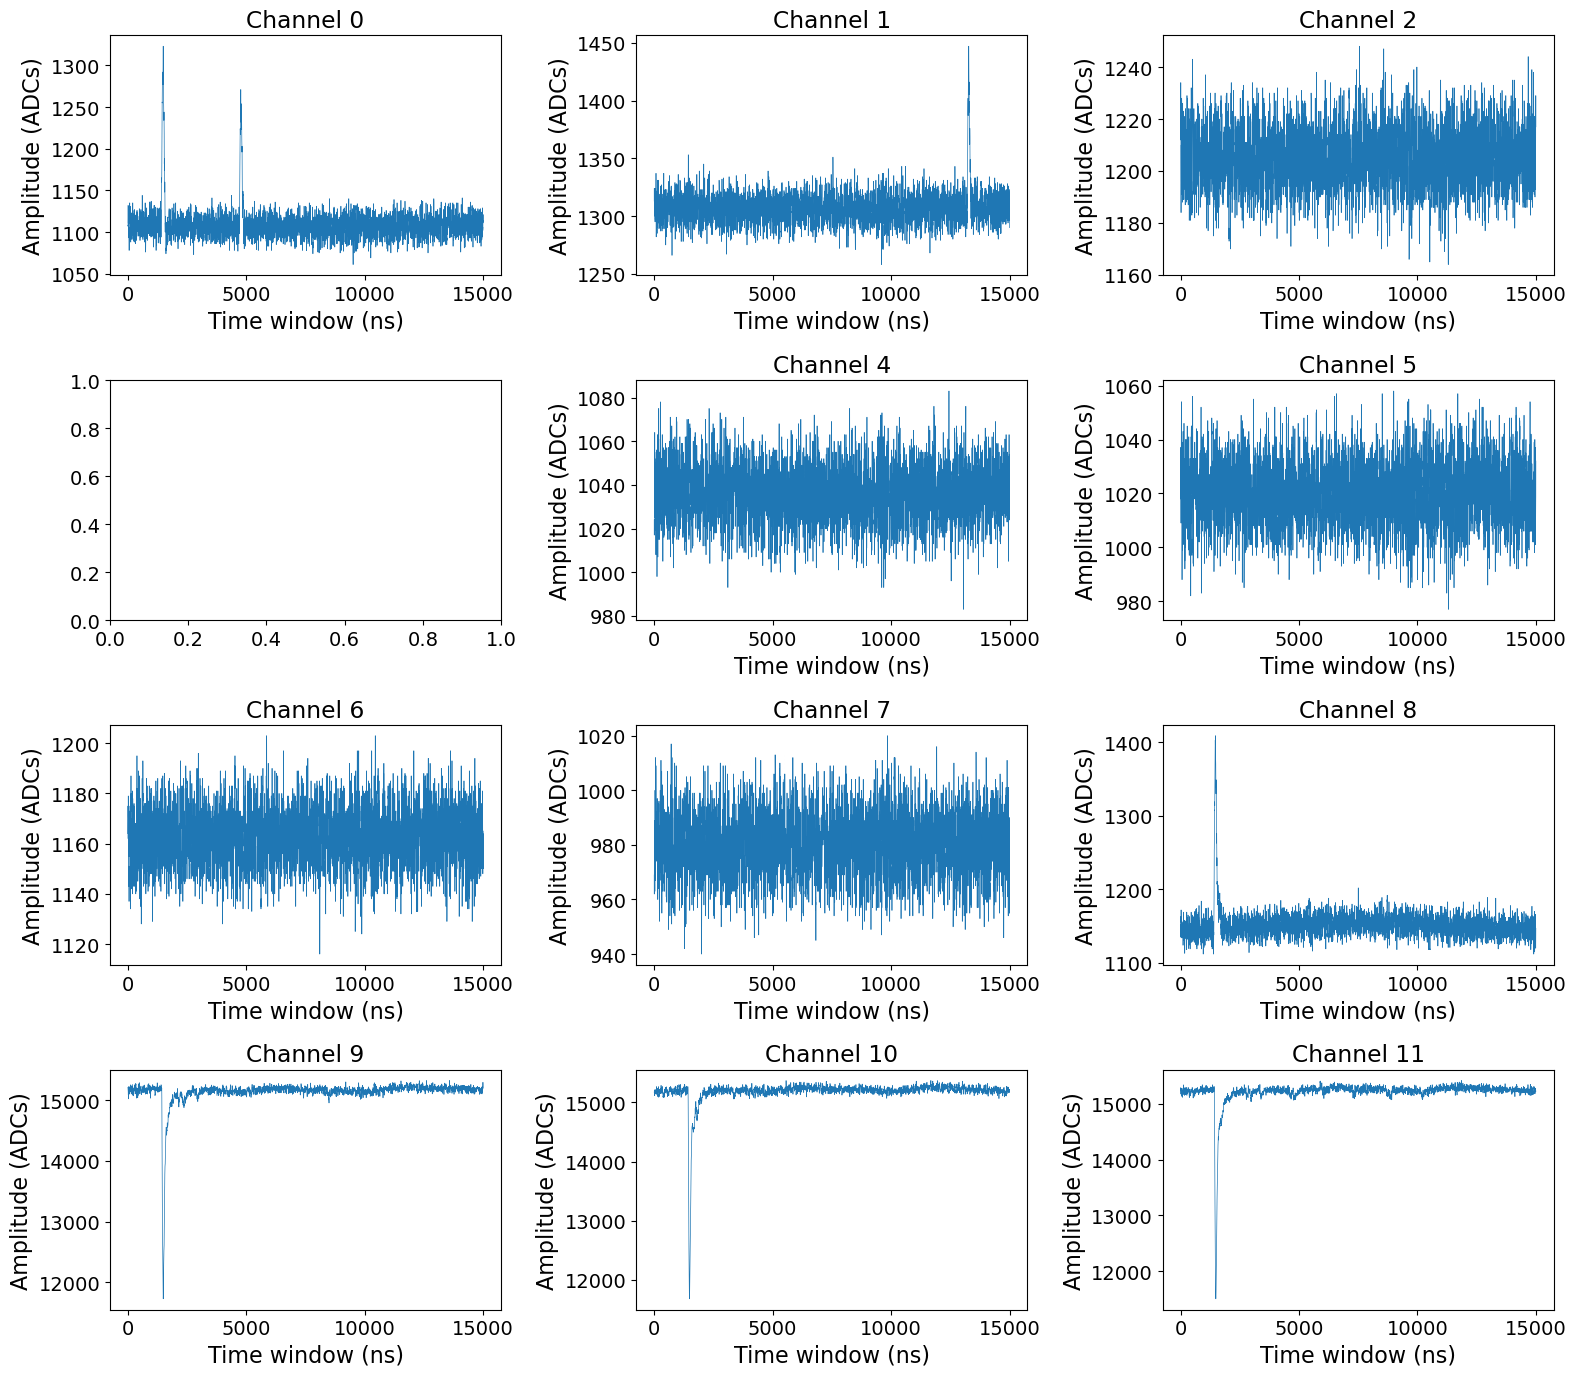

In [6]:
choose_evt = 4
fig, axs = plt.subplots(4, 3, figsize=(16, 14))
for k in range(12):
    if k==3: continue
    i = int(k/3)
    j = k%3
    wf = np.array(RawTree[f'chan{k}/rdigi'].array())[choose_evt]
    axs[i][j].plot(2*np.arange(len(wf)), wf, linewidth=0.5)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=16)
    axs[i][j].set_ylabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_title(f"Channel {k}")
plt.tight_layout()
plt.show()

### PMT

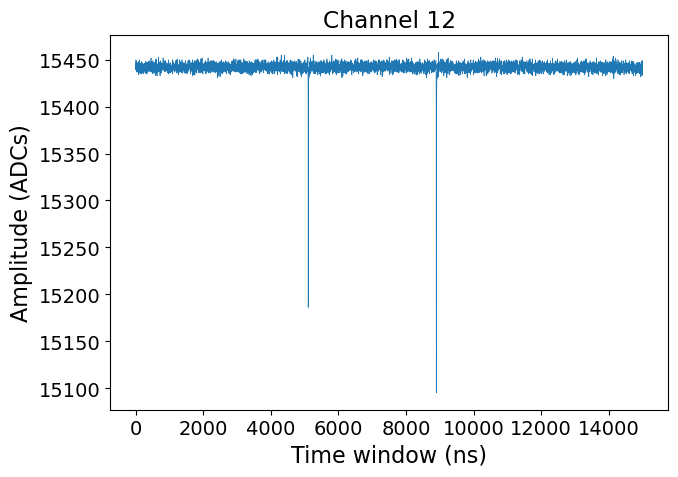

In [7]:
plt.figure(figsize=(7, 5))
channel  = 12
wf = np.array(RawTree[f'chan{channel}/rdigi'].array())[choose_evt]
plt.plot(2*np.arange(len(wf)), wf, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADCs)', fontsize=16)
plt.title(f"Channel {channel}")
plt.tight_layout()
plt.show()

## All channels for one event:

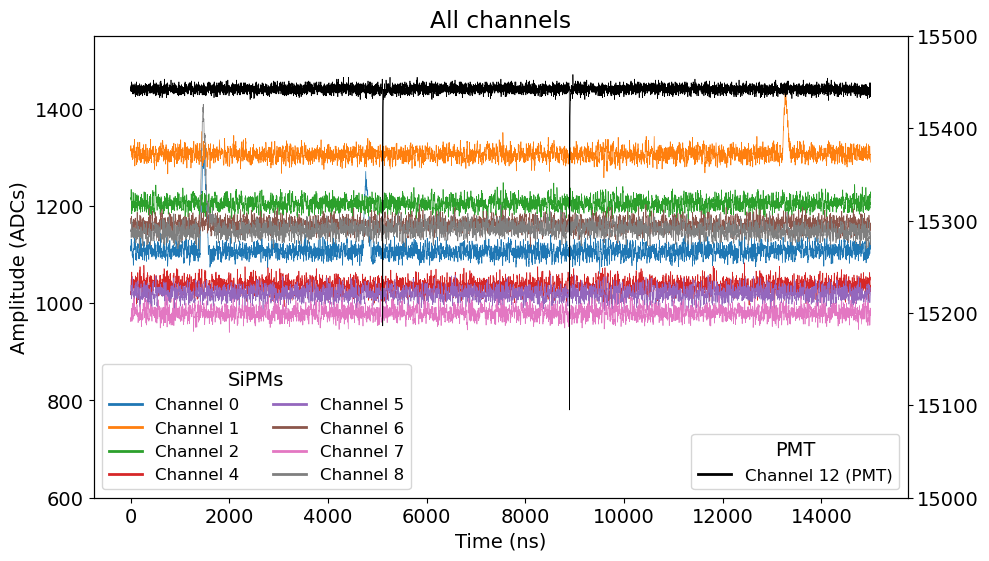

In [8]:
evt = 4
num_channels = 9

fig, ax0 = plt.subplots(figsize=(10.5,6))
for channel in range(num_channels):
    if channel==3: continue

    wf = np.array(RawTree[f'chan{channel}/rdigi'].array())[evt]
    ax0.plot(2*np.arange(len(wf)), wf, linewidth=0.5, label=f"Channel {channel}")

    ax0.set_xlabel('Time (ns)')
    ax0.set_ylabel('Amplitude (ADCs)')
    ax0.set_title('All channels')
    
ax1 = ax0.twinx()
ax1.plot(2*np.arange(len(wf)), np.array(RawTree[f'chan12/rdigi'].array())[evt], linewidth=0.5, label=f"Channel 12 (PMT)", color='k')

ax0.set_ylim(600, 1550)
ax1.set_ylim(15000, 15500)
leg0 = ax0.legend(fontsize=12, loc='lower left', ncol=2, title='SiPMs')
leg1 = ax1.legend(fontsize=12, loc='lower right',        title='PMT')

for ich in range(num_channels-1):
    leg0.get_lines()[ich].set_linewidth(2)
leg1.get_lines()[0].set_linewidth(2)
plt.show()

## Different ways to compute the baseline, I used to use the mode

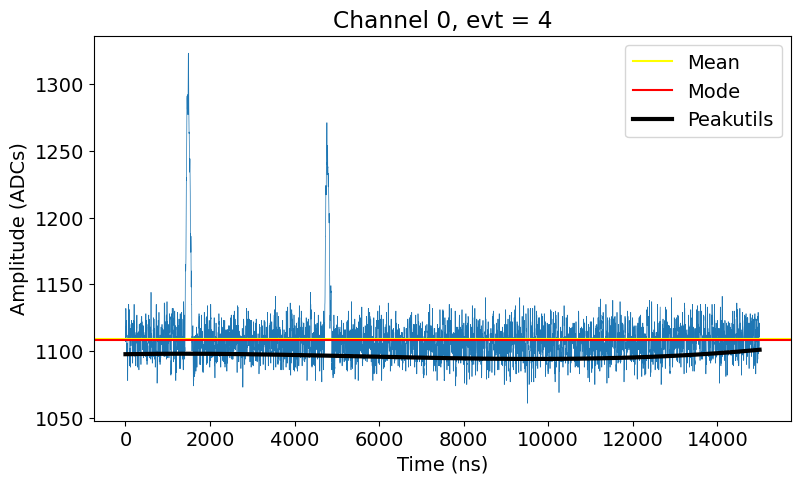

In [9]:
channel  = 0
evt      = 4
fig = plt.figure(figsize=(9, 5))
wf = np.array(RawTree[f'chan{channel}/rdigi'].array())[evt]
plt.plot(2*np.arange(len(wf)), wf, linewidth=0.5)
plt.axhline(np.mean(wf.astype(float)), color='yellow', label='Mean')
plt.axhline(st.mode(wf.astype(float), keepdims=False).mode, color='r', label='Mode')
plt.plot(2*np.arange(len(wf)), peakutils.baseline(wf.astype(float)), linewidth=3, color='k', label='Peakutils')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (ADCs)')
plt.title(f"Channel {channel}, evt = {evt}")
plt.legend()
plt.show()

## Subtract baseline using the mode (with the function subtract_baseline defined in peak_functions)

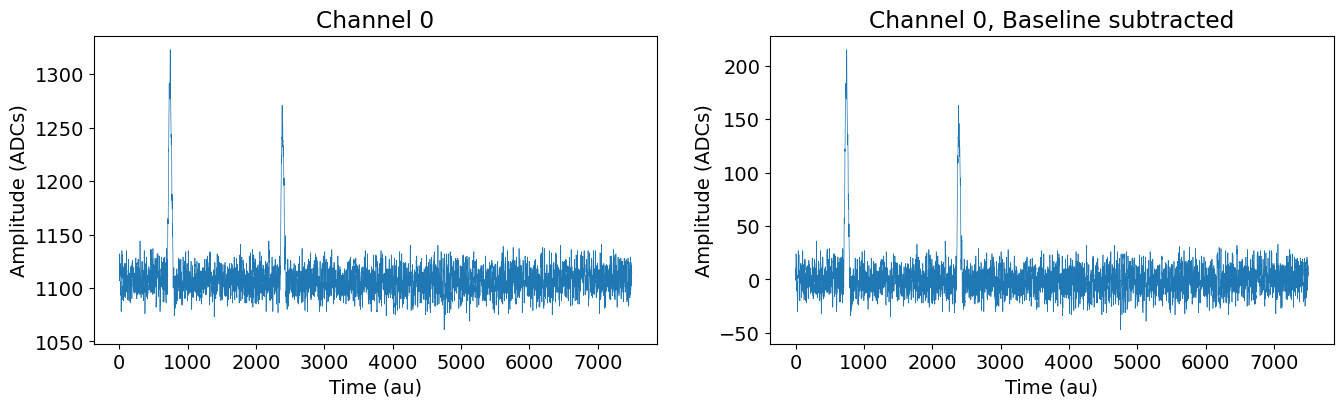

In [10]:
channel = 0
evt     = 4

sel_raw_wf = np.array(RawTree[f'chan{channel}/rdigi'].array())[evt]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
ax0.plot(sel_raw_wf, linewidth=0.5)
ax0.set_ylabel('Amplitude (ADCs)')
ax0.set_title(f"Channel {channel}")
ax0.set_xlabel('Time (au)')

ax1.plot(pf.subtract_baseline(sel_raw_wf), linewidth=0.5)
ax1.set_ylabel('Amplitude (ADCs)')
ax1.set_title(f"Channel {channel}, Baseline subtracted")
ax1.set_xlabel('Time (au)')
plt.show()

### Histogram the wf to decide which threshold apply

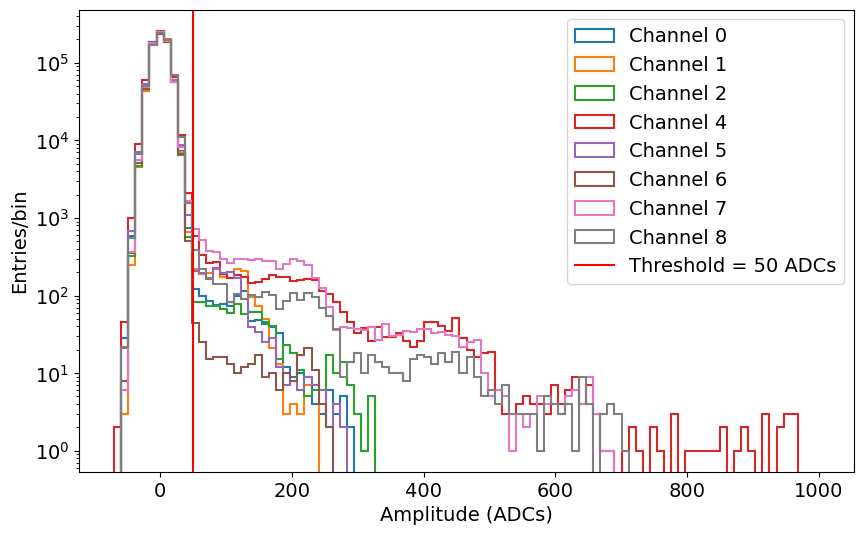

In [11]:
plt.figure(figsize=(10, 6))
for channel in range(9):
    if channel==3:
        continue
    sel_raw_wf  = np.array(RawTree[f'chan{channel}/rdigi'].array())
    raw_wf_subt = list(map(pf.subtract_baseline, sel_raw_wf[:100]))
    plt.hist(np.concatenate(raw_wf_subt), bins=100, range=(-70, 1000), log=True, histtype='step', linewidth=1.5, label=f'Channel {channel}'); 
plt.axvline(x=50, color='r', label='Threshold = 50 ADCs')
plt.xlabel('Amplitude (ADCs)')
plt.ylabel('Entries/bin')
plt.legend()
plt.show()

#### 50 ADCs seems to be a good threshold

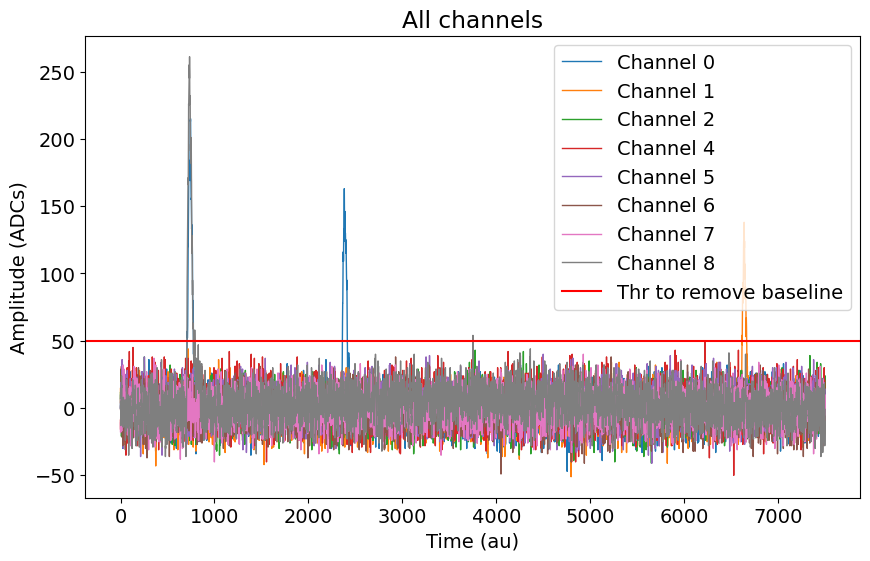

In [12]:
evt = 4

fig = plt.figure(figsize=(10, 6))
for channel in range(9):
    if channel==3: continue

    sel_raw_wf = np.array(RawTree[f'chan{channel}/rdigi'].array())[evt]

    plt.plot(pf.subtract_baseline(sel_raw_wf), linewidth=1, label=f"Channel {channel}")
    plt.xlabel('Time (au)')
    plt.ylabel('Amplitude (ADCs)')
    plt.title('All channels')
    
plt.axhline(y = 50, color='r', label='Thr to remove baseline')
plt.legend()
plt.show()

### Michael suggested to fit a gaussian and compute the threshold as $\sigma$ *5

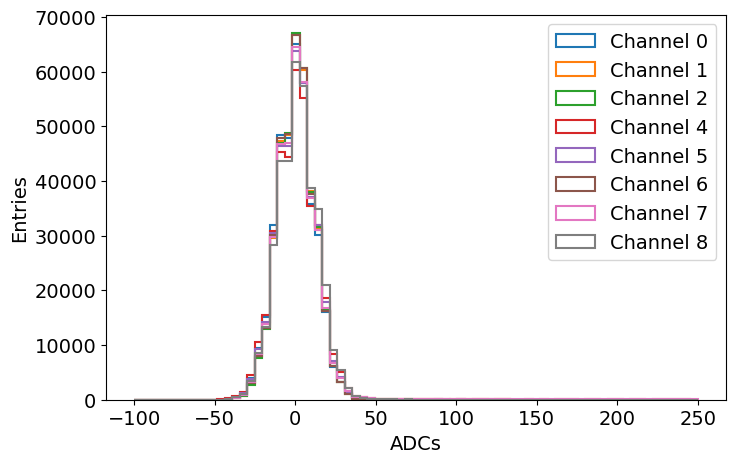

In [13]:
plt.figure(figsize=(8, 5))
for channel in range(9):
    if channel==3:
        continue
    sel_raw_wf  = np.array(RawTree[f'chan{channel}/rdigi'].array())
    raw_wf_subt = list(map(pf.subtract_baseline, sel_raw_wf[:50]))
    plt.hist(np.concatenate(raw_wf_subt), bins=75, range=(-100, 250), histtype='step', linewidth=1.5, label=f'Channel {channel}'); 
plt.xlabel('ADCs')
plt.ylabel('Entries')
plt.legend()
plt.show()

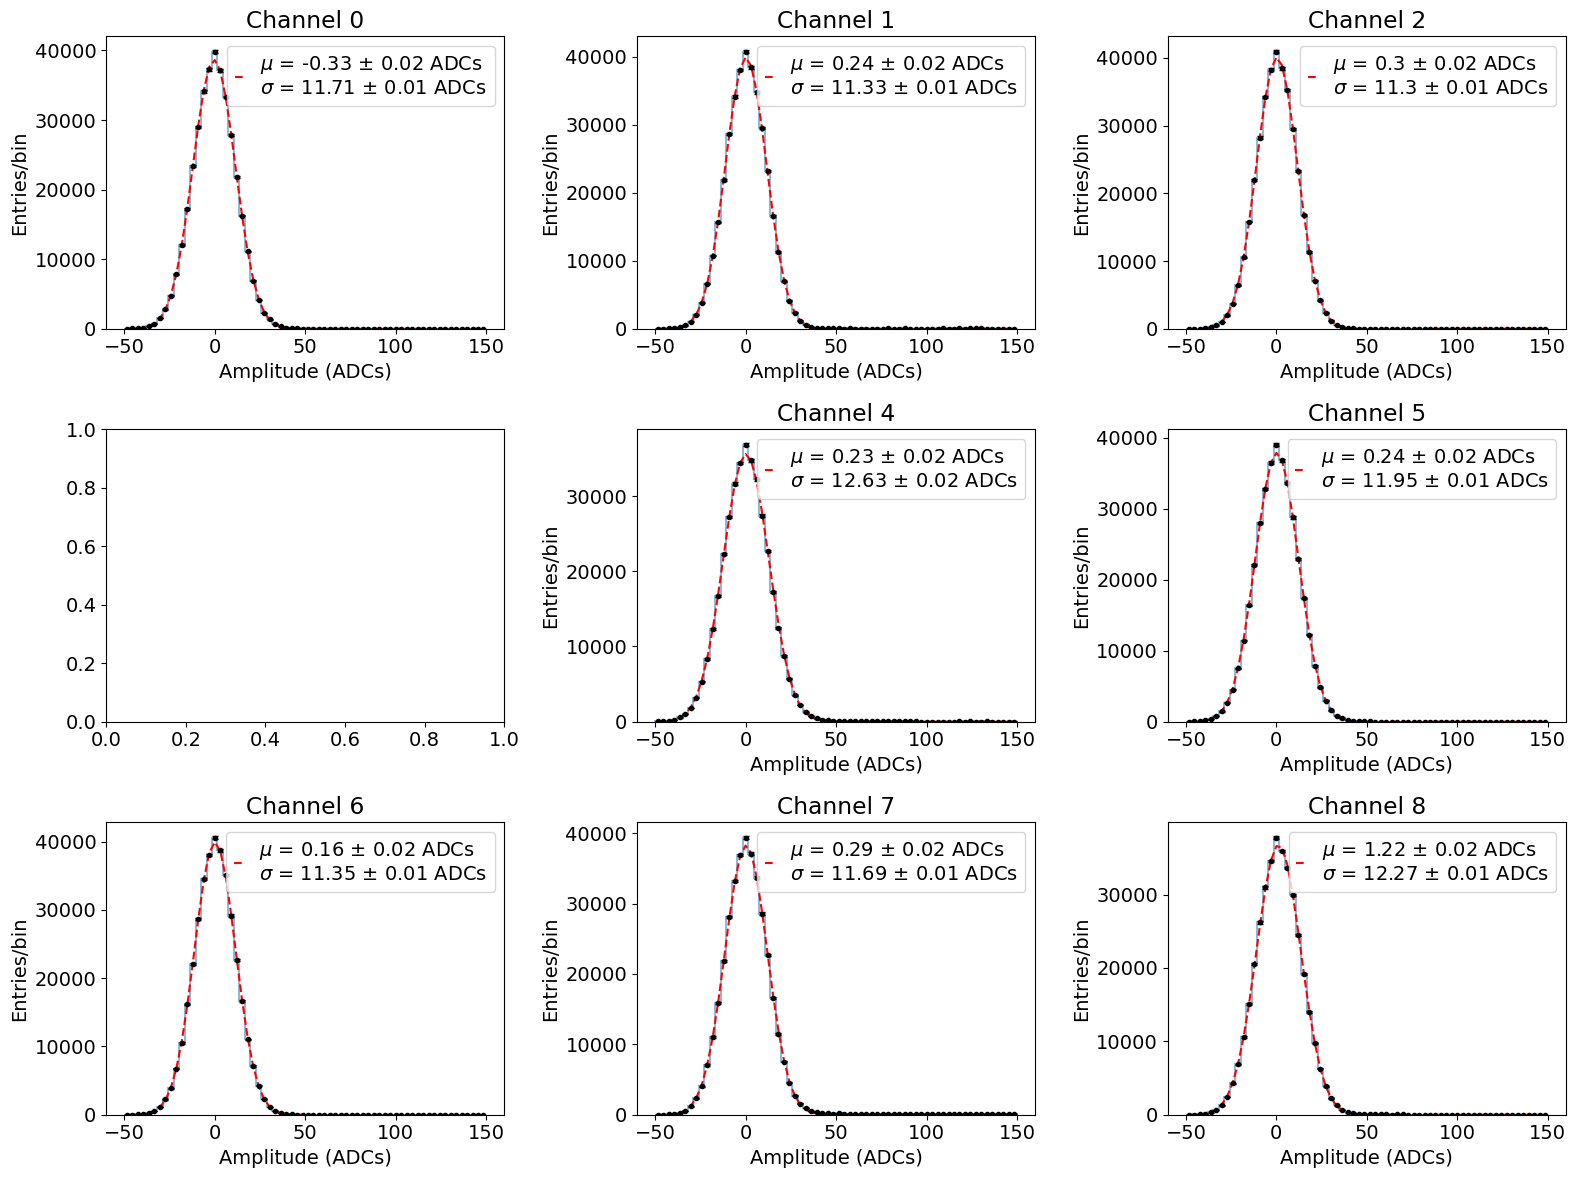

In [14]:
all_sigmas = []
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    if k==3: continue
    i = int(k/3)
    j = k%3    
    sel_raw_wf  = np.array(RawTree[f'chan{k}/rdigi'].array())
    raw_wf_subt = np.concatenate(list(map(pf.subtract_baseline, sel_raw_wf[:50])))
    sel = raw_wf_subt < 150
    
    _, _, sigma, _, _, _, _ = fitf.gaussian_fit_IC_subplot(axs[i][j], raw_wf_subt[sel], bins=66, ampl=10000, mean=0, sigma=10, frange=(-50, 50), title=f'Channel {k}', print_chi2=False)
    all_sigmas.append(sigma)

plt.tight_layout()
plt.show()

all_sigmas = np.array(all_sigmas)

#### Thresholds using  $\sigma$ * 5 are above 50 ADCs

In [15]:
all_sigmas*5

array([58.57175619, 56.65511295, 56.47938564, 63.147839  , 59.74154145,
       56.73687654, 58.46433217, 61.33804237])

## Peak finder: there are 2 methods to determine the number of photons corresponding to each peak
### - Height of the pulse
### - Area of the pulse (integration)

##### From now on the analysis have been performed using the 50 ADCs threshold

### Height of the pulse: (example for 3 events)

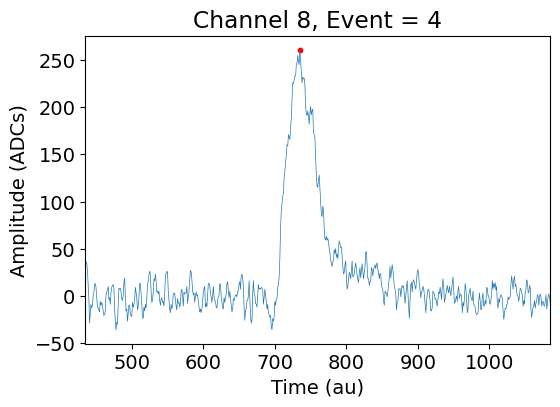

261.0  ADCs, Wf position:  735


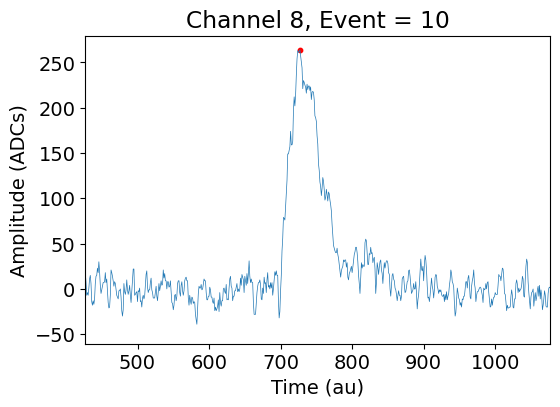

264.0  ADCs, Wf position:  727


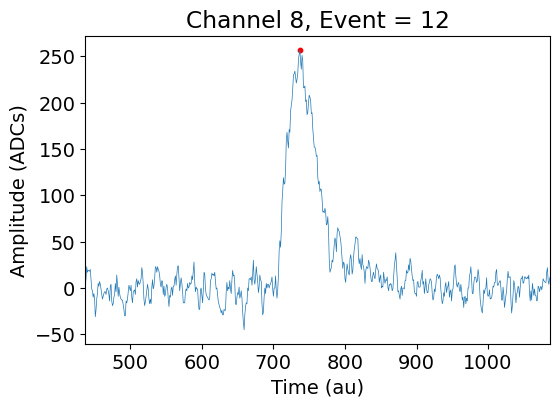

257.0  ADCs, Wf position:  737


In [16]:
channel = 8

for evt in [4, 10, 12]:
    sel_raw_wf = np.array(RawTree[f'chan{channel}/rdigi'].array())[evt]
    wf_bs_subt = pf.subtract_baseline(sel_raw_wf)
    peaks      = peakutils.indexes(wf_bs_subt, thres=0.35, min_dist=100)
    
    fig = plt.figure(figsize=(6, 4))
    plt.plot(wf_bs_subt, linewidth=0.5)
    plt.scatter(np.arange(len(wf_bs_subt))[peaks], wf_bs_subt[peaks], color='red', marker='o', label='Peaks', s=10)
    plt.ylabel('Amplitude (ADCs)')
    plt.title(f"Channel {channel}, Event = {evt}")
    plt.xlabel('Time (au)')
    if len(peaks)==1:
        plt.xlim(peaks[0]-300, peaks[0]+350)
    else:
        plt.xlim(peaks[0]-300, peaks[-1]+350)
    plt.show()

    print(wf_bs_subt[peaks][0], ' ADCs, Wf position: ', peaks[0])

## Area/integral of the pulse

### Two methods:
#### - Zero suppression (filter the waveform with the chosen threshold and convert the rest of the waveform into zeros)
#### - Sum all the peak values until the waveform gets a negative value (this is what Michael does)

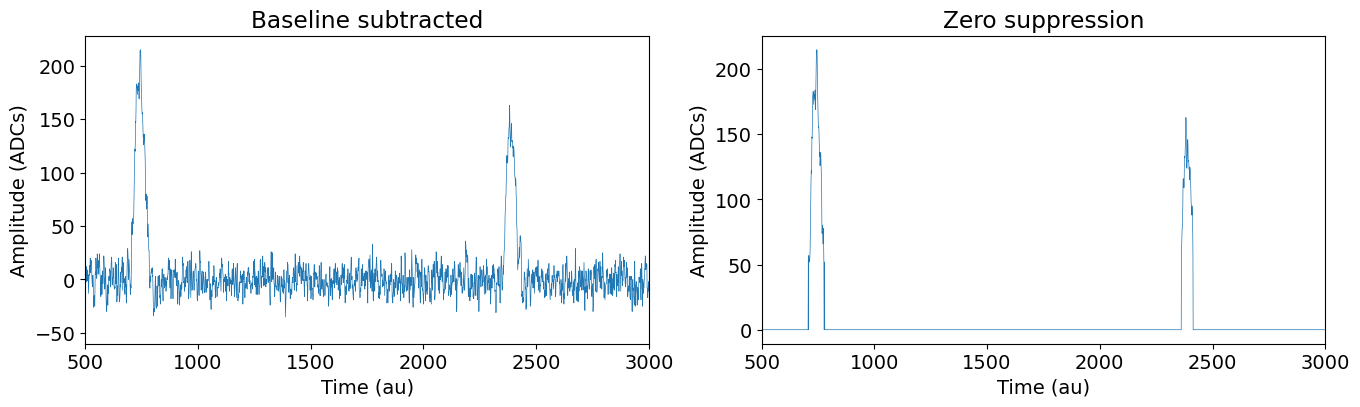

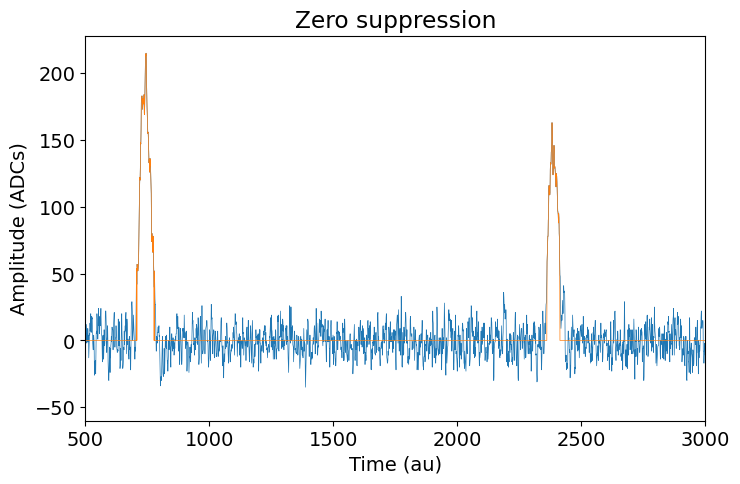

In [17]:
channel  = 0
evt      = 4
sipm_thr = 50

sel_raw_wf  = np.array(RawTree[f'chan{channel}/rdigi'].array())[evt]
subt_raw_wf = pf.subtract_baseline(sel_raw_wf)
zs_raw_wf   = pf.noise_suppression(subt_raw_wf, sipm_thr)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
ax0.plot(subt_raw_wf, linewidth=0.5)
ax0.set_xlim(500,3000)
ax0.set_ylabel('Amplitude (ADCs)')
ax0.set_title("Baseline subtracted")
ax0.set_xlabel('Time (au)')

ax1.plot(zs_raw_wf, linewidth=0.5)
ax1.set_xlim(500,3000)
ax1.set_ylabel('Amplitude (ADCs)')
ax1.set_title("Zero suppression")
ax1.set_xlabel('Time (au)')
plt.show()


fig = plt.figure(figsize=(8,5))
plt.plot(subt_raw_wf, linewidth=0.5)
plt.plot(zs_raw_wf, linewidth=0.5)
plt.xlim(500,3000)
plt.ylabel('Amplitude (ADCs)')
plt.title("Zero suppression")
plt.xlabel('Time (au)')
plt.show()

#### The problem here is that the afterpulsing below the threshold is lost

## Comparison between Zero Suppression and Integration of positive values

In [18]:
channel      = 7
raw_wf       = np.array(RawTree[f'chan{channel}/rdigi'].array())[18]
subt_raw_wf  = pf.subtract_baseline(raw_wf)
zs_raw_wf    = pf.noise_suppression(subt_raw_wf, threshold=50)

filter_empty_wf  = zs_raw_wf #zs_raw_wfs[np.any(zs_raw_wfs != 0, axis=1)]
all_peaks        = pf.get_peaks_peakutils(filter_empty_wf)

total_int   = []
peaks_indxs = []
for p_wk in all_peaks:
    peak_indxs     = []
    int_peak       = subt_raw_wf[p_wk]
    next_val_left  = p_wk
    next_val_right = p_wk
    for wf_val in range(len(subt_raw_wf)):
        peak_indxs.append(next_val_left)
        next_val_left -= 1
        if subt_raw_wf[next_val_left]<0:
            break
    for wf_val in range(len(subt_raw_wf)):
        next_val_right += 1
        if subt_raw_wf[next_val_right]<0:
            break
        peak_indxs.append(next_val_right)
    total_int.append(int_peak)
    peaks_indxs.append(np.array(peak_indxs))

total_int = np.array([np.sum(subt_raw_wf[idx]) for idx in peaks_indxs])

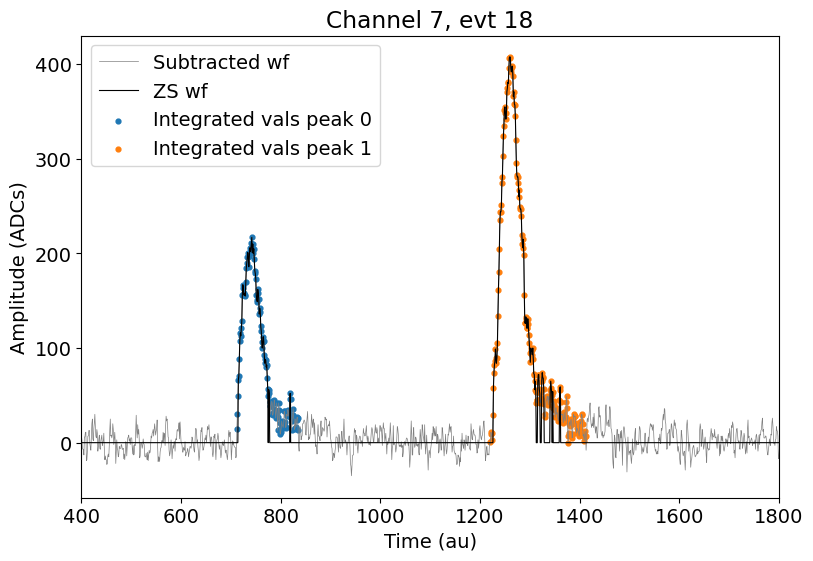

In [19]:
fig = plt.figure(figsize=(9, 6))
plt.plot(subt_raw_wf, linewidth=0.5, color='grey', label='Subtracted wf')
plt.plot(zs_raw_wf,   linewidth=0.8, color='k',    label='ZS wf')
for i, el in enumerate(peaks_indxs):
    plt.scatter(np.arange(len(subt_raw_wf))[el], subt_raw_wf[el], s=12, label=f'Integrated vals peak {i}')
plt.xlim(400,1800)
plt.title(f'Channel {channel}, evt 18')
plt.xlabel('Time (au)')
plt.ylabel('Amplitude (ADCs)')
plt.legend()
plt.show()

## Analysis of files with the 3 methods:
    - Height of the peaks
    - Integration until the wf reaches negative values
    - integration with Zero Suppression

#### The script used is:
get_peak_height_and_area.py

In [20]:
evts_path = '/Users/romoluque_c/LEGEND/BACON/data_npz/'

all_channels = 9

peak_heigh_all_channels_dict   = {}
peak_area_all_channels_dict    = {}
peak_area_zs_all_channels_dict = {}

def get_date(filename):
    date_str = filename[31:41]
    date = datetime.strptime(date_str, '%m_%d_%Y')
    return date

files        = os.listdir(evts_path)
sorted_files = sorted(files, key=get_date)

for filename in sorted_files:
    my_file = evts_path+filename
    d = np.load(my_file, allow_pickle=True)
    
    date = filename[31:41]
    
    if date not in peak_heigh_all_channels_dict:
        peak_heigh_all_channels   = [np.array([]) for _ in range(all_channels)]
        peak_area_all_channels    = [np.array([]) for _ in range(all_channels)]
        peak_area_zs_all_channels = [np.array([]) for _ in range(all_channels)]

    for channel in range(all_channels):
        if channel==3:
            continue
        if len(d['peak_heigh_all_channels'])<8:
            if channel==7:
                continue
            elif channel>7:
                peak_heigh_all_channels  [channel] = np.concatenate((peak_heigh_all_channels  [channel], d['peak_heigh_all_channels']  [channel-2]))
                peak_area_all_channels   [channel] = np.concatenate((peak_area_all_channels   [channel], d['peak_area_all_channels']   [channel-2]))
                peak_area_zs_all_channels[channel] = np.concatenate((peak_area_zs_all_channels[channel], d['peak_area_zs_all_channels'][channel-2]))
                continue
        if channel > 3:
            peak_heigh_all_channels  [channel] = np.concatenate((peak_heigh_all_channels  [channel], d['peak_heigh_all_channels']  [channel-1]))
            peak_area_all_channels   [channel] = np.concatenate((peak_area_all_channels   [channel], d['peak_area_all_channels']   [channel-1]))
            peak_area_zs_all_channels[channel] = np.concatenate((peak_area_zs_all_channels[channel], d['peak_area_zs_all_channels'][channel-1]))
        else:
            peak_heigh_all_channels  [channel] = np.concatenate((peak_heigh_all_channels  [channel], d['peak_heigh_all_channels']  [channel]))
            peak_area_all_channels   [channel] = np.concatenate((peak_area_all_channels   [channel], d['peak_area_all_channels']   [channel]))
            peak_area_zs_all_channels[channel] = np.concatenate((peak_area_zs_all_channels[channel], d['peak_area_zs_all_channels'][channel]))

    peak_heigh_all_channels_dict  [filename[31:41]] = np.array(peak_heigh_all_channels  , dtype=object)
    peak_area_all_channels_dict   [filename[31:41]] = np.array(peak_area_all_channels   , dtype=object)
    peak_area_zs_all_channels_dict[filename[31:41]] = np.array(peak_area_zs_all_channels, dtype=object)

### Height of the peak:


                      ---------------------------------------
                      ----- No XENON (low light levels) -----
                      ---------------------------------------



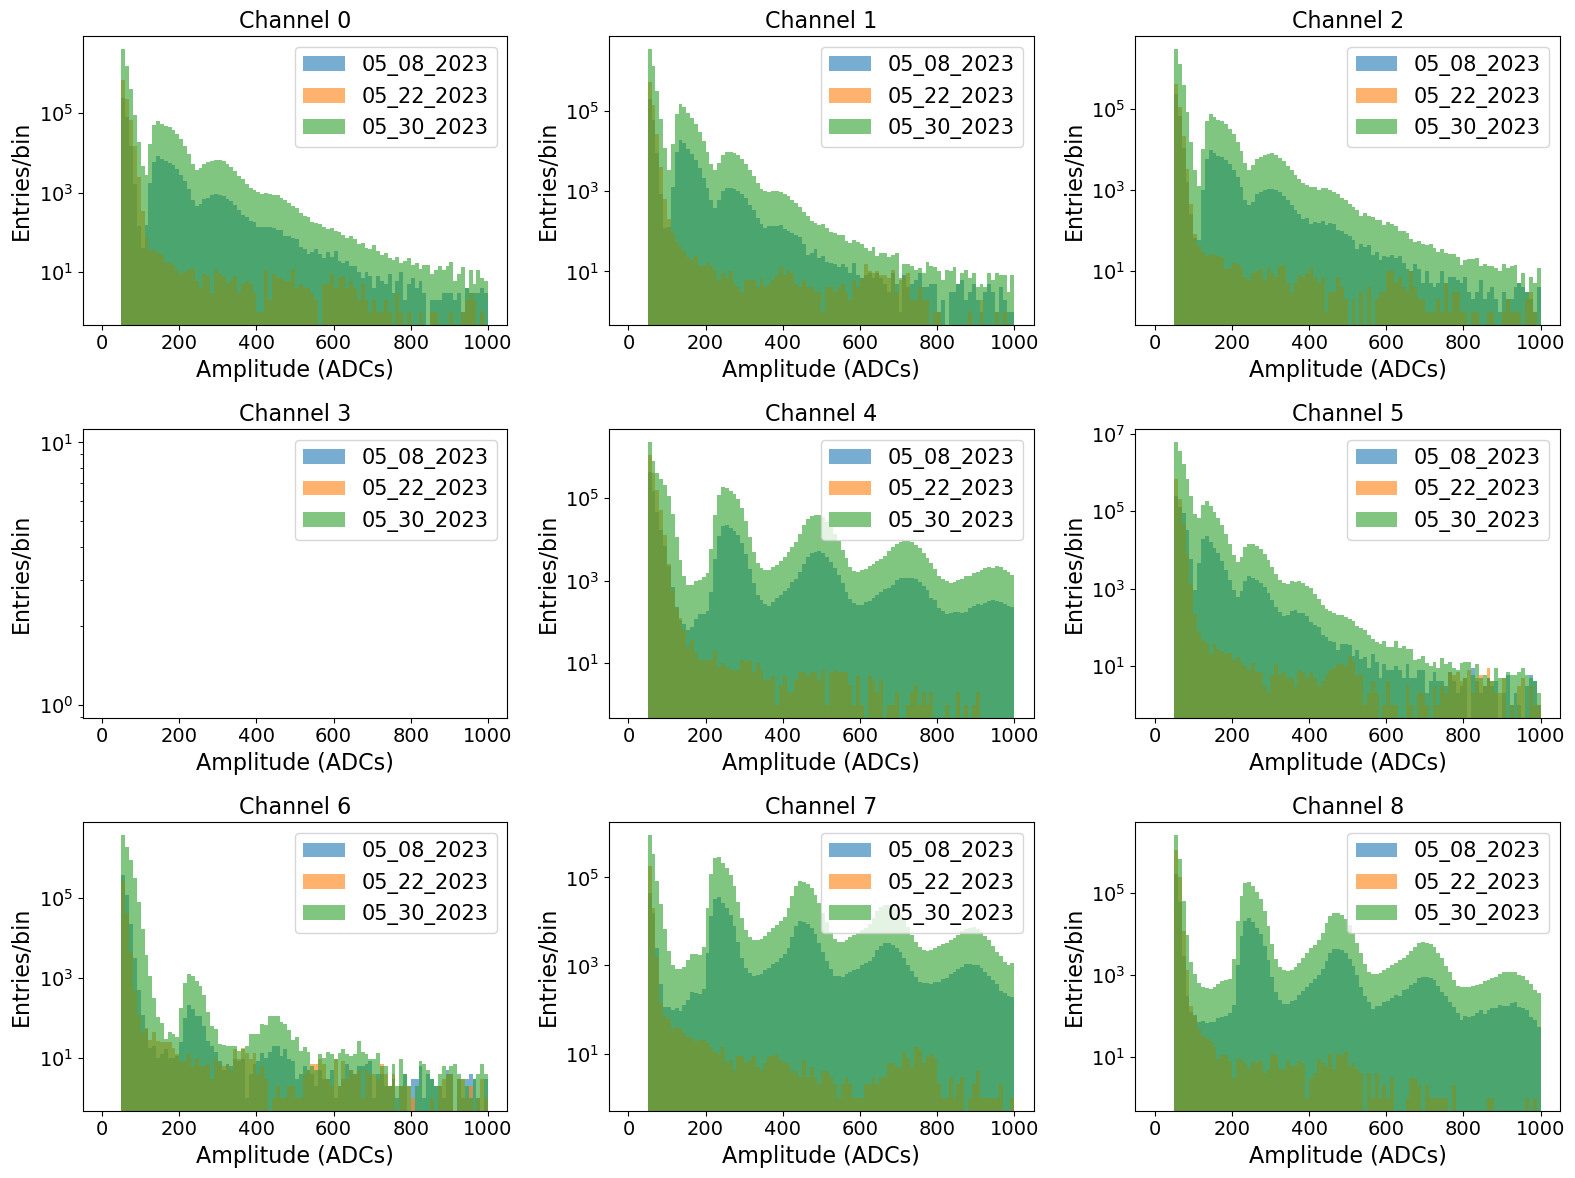

In [21]:
print('')
print('                      ---------------------------------------')
print('                      ----- No XENON (low light levels) -----')
print('                      ---------------------------------------')
print('')

select_date1 = '05_08_2023'
select_date2 = '05_22_2023'
select_date3 = '05_30_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date1][k], bins=100, range=(0,1000), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date2][k], bins=100, range=(0,1000), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date3][k], bins=100, range=(0,1000), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      ----- No XENON (high light levels) ----
                      ---------------------------------------



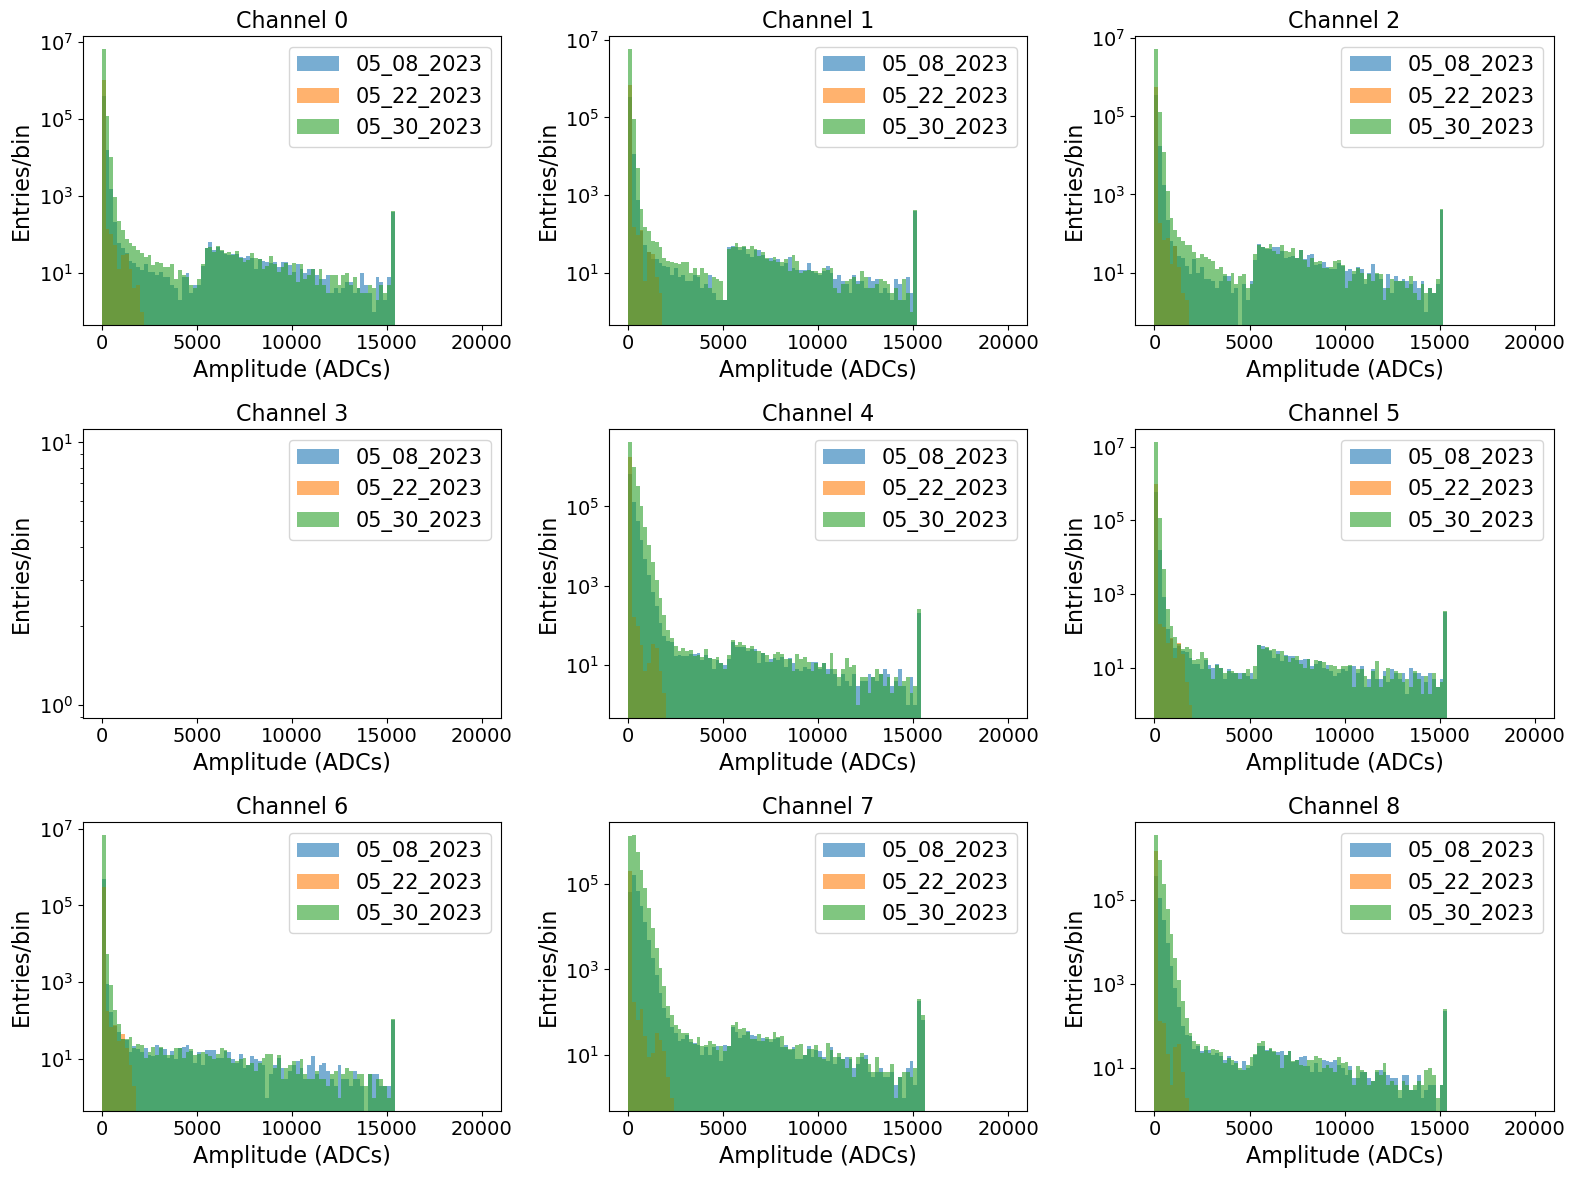

In [22]:
print('')
print('                      ---------------------------------------')
print('                      ----- No XENON (high light levels) ----')
print('                      ---------------------------------------')
print('')

select_date1 = '05_08_2023'
select_date2 = '05_22_2023'
select_date3 = '05_30_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date1][k], bins=100, range=(0,20000), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date2][k], bins=100, range=(0,20000), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date3][k], bins=100, range=(0,20000), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      --- 0.1 ppm XENON (low light levels) --
                      ---------------------------------------



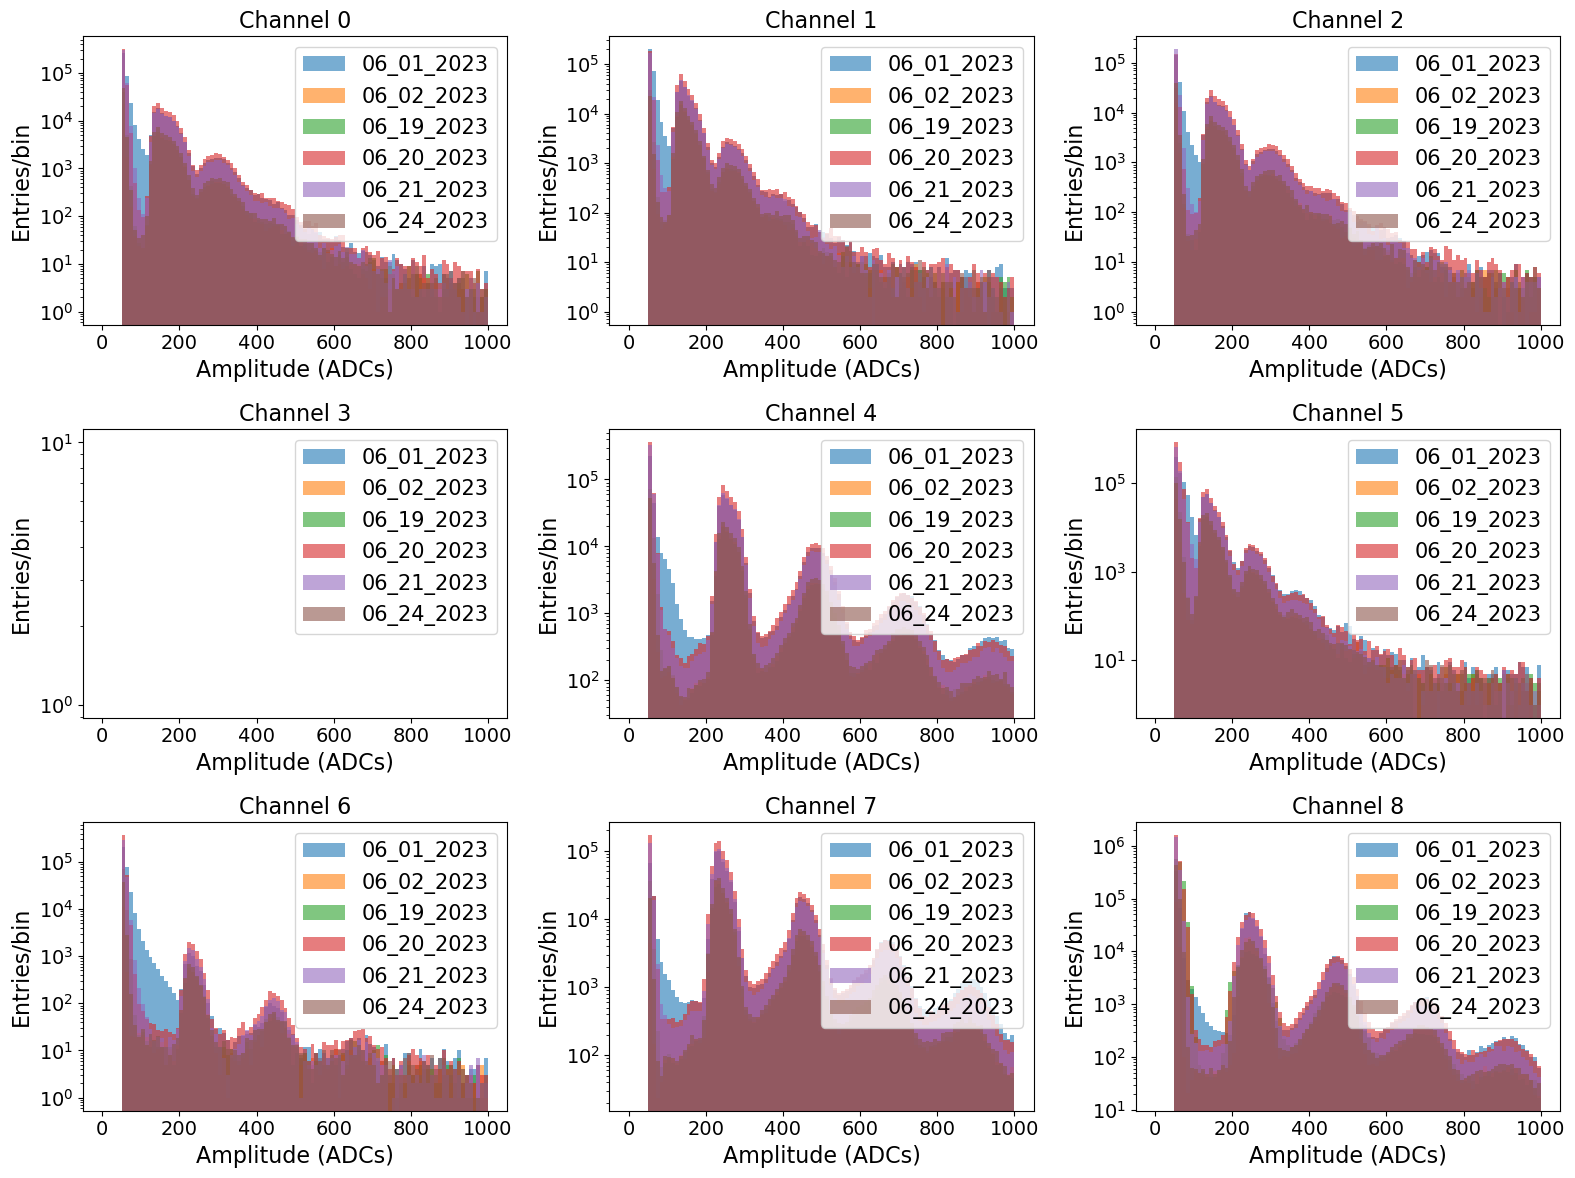

In [23]:
print('')
print('                      ---------------------------------------')
print('                      --- 0.1 ppm XENON (low light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '06_01_2023'
select_date2 = '06_02_2023'
select_date3 = '06_19_2023'
select_date4 = '06_20_2023'
select_date5 = '06_21_2023'
select_date6 = '06_24_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date1][k], bins=100, range=(0,1000), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date2][k], bins=100, range=(0,1000), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date3][k], bins=100, range=(0,1000), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date4][k], bins=100, range=(0,1000), log=True, label=f'{select_date4}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date5][k], bins=100, range=(0,1000), log=True, label=f'{select_date5}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date6][k], bins=100, range=(0,1000), log=True, label=f'{select_date6}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      -- 0.1 ppm XENON (high light levels) --
                      ---------------------------------------



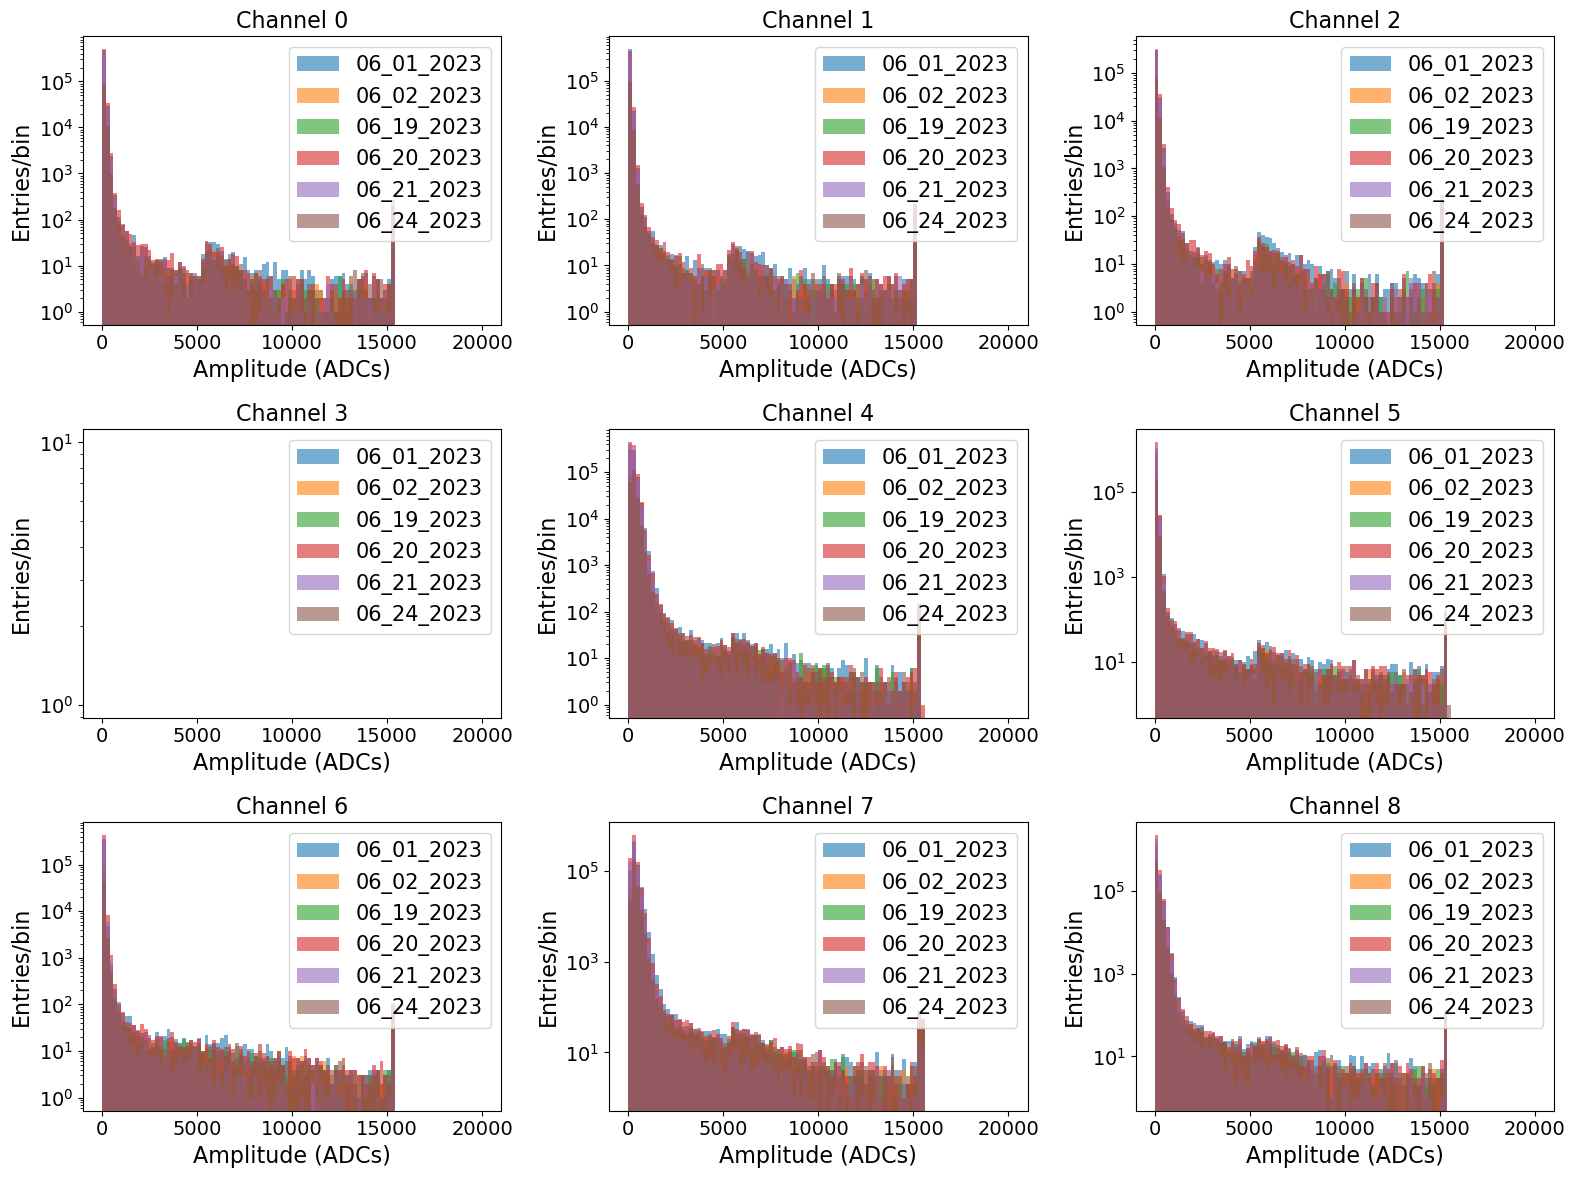

In [24]:
print('')
print('                      ---------------------------------------')
print('                      -- 0.1 ppm XENON (high light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '06_01_2023'
select_date2 = '06_02_2023'
select_date3 = '06_19_2023'
select_date4 = '06_20_2023'
select_date5 = '06_21_2023'
select_date6 = '06_24_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date1][k], bins=100, range=(0,20000), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date2][k], bins=100, range=(0,20000), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date3][k], bins=100, range=(0,20000), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date4][k], bins=100, range=(0,20000), log=True, label=f'{select_date4}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date5][k], bins=100, range=(0,20000), log=True, label=f'{select_date5}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date6][k], bins=100, range=(0,20000), log=True, label=f'{select_date6}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      --- 0.2 ppm XENON (low light levels) --
                      ---------------------------------------



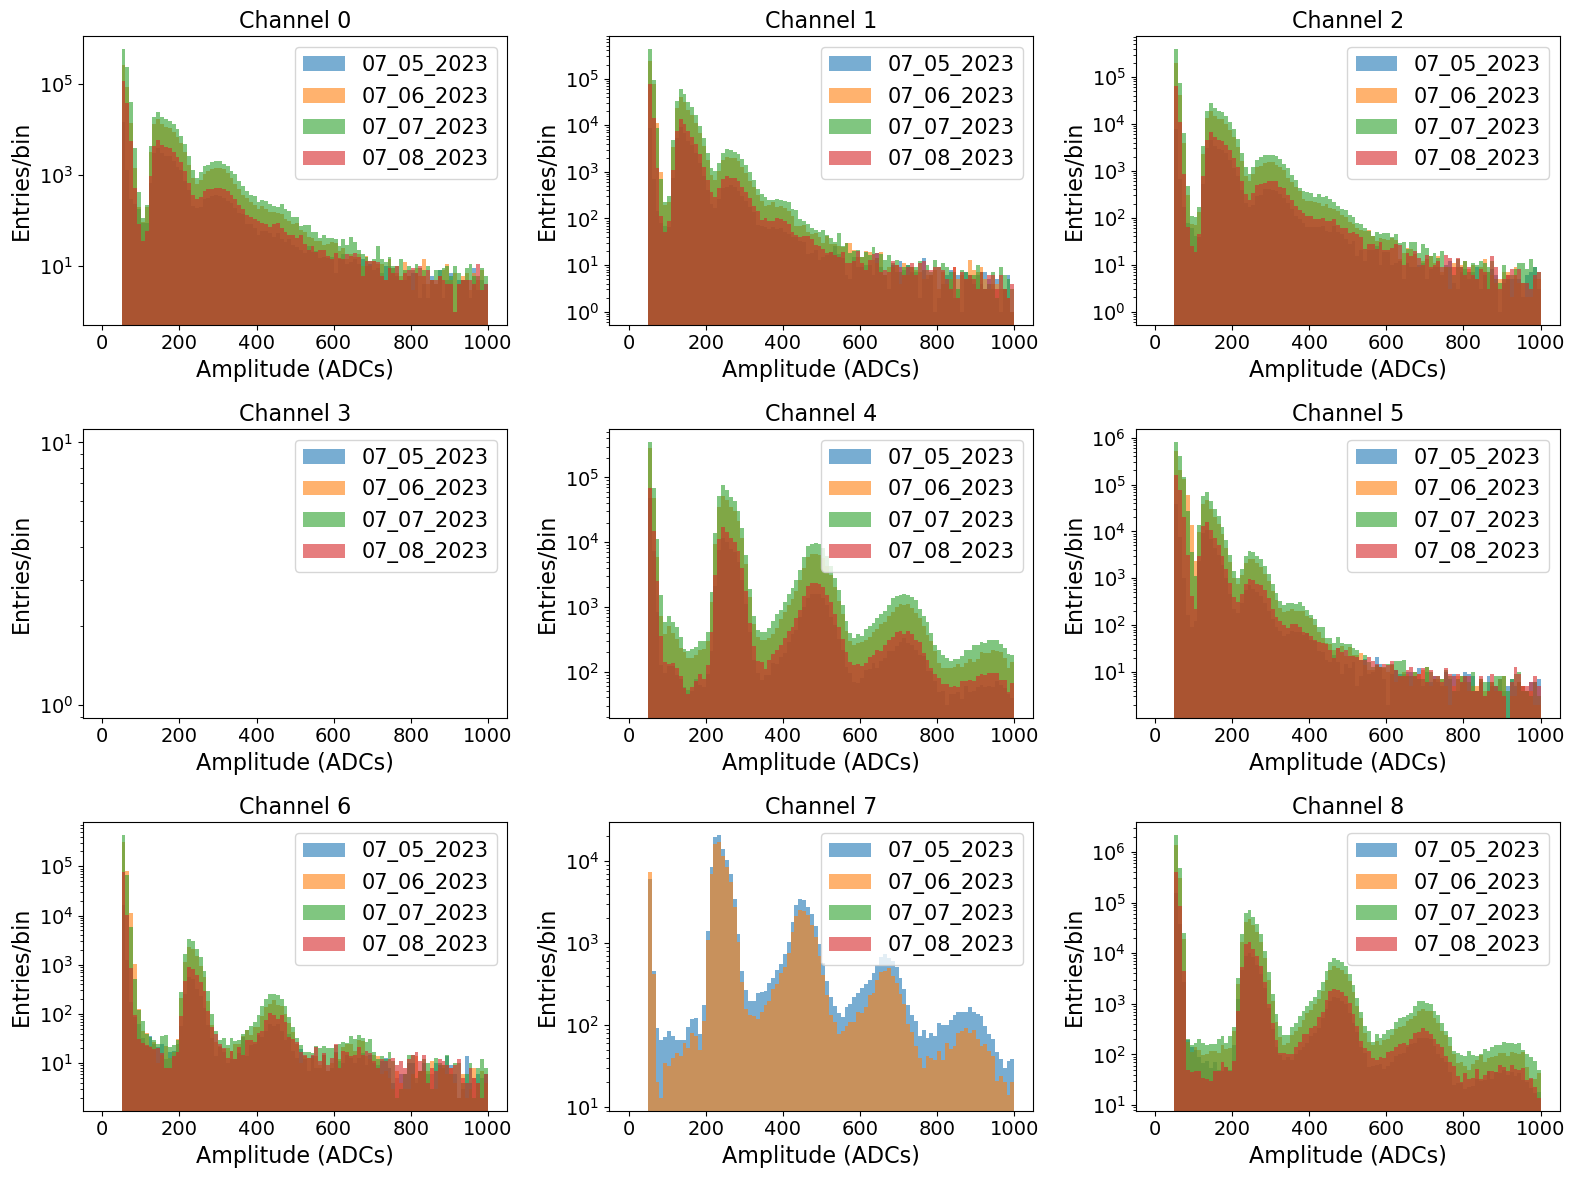

In [25]:
print('')
print('                      ---------------------------------------')
print('                      --- 0.2 ppm XENON (low light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '07_05_2023'
select_date2 = '07_06_2023'
select_date3 = '07_07_2023'
select_date4 = '07_08_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date1][k], bins=100, range=(0,1000), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date2][k], bins=100, range=(0,1000), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date3][k], bins=100, range=(0,1000), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date4][k], bins=100, range=(0,1000), log=True, label=f'{select_date4}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      -- 0.2 ppm XENON (high light levels) --
                      ---------------------------------------



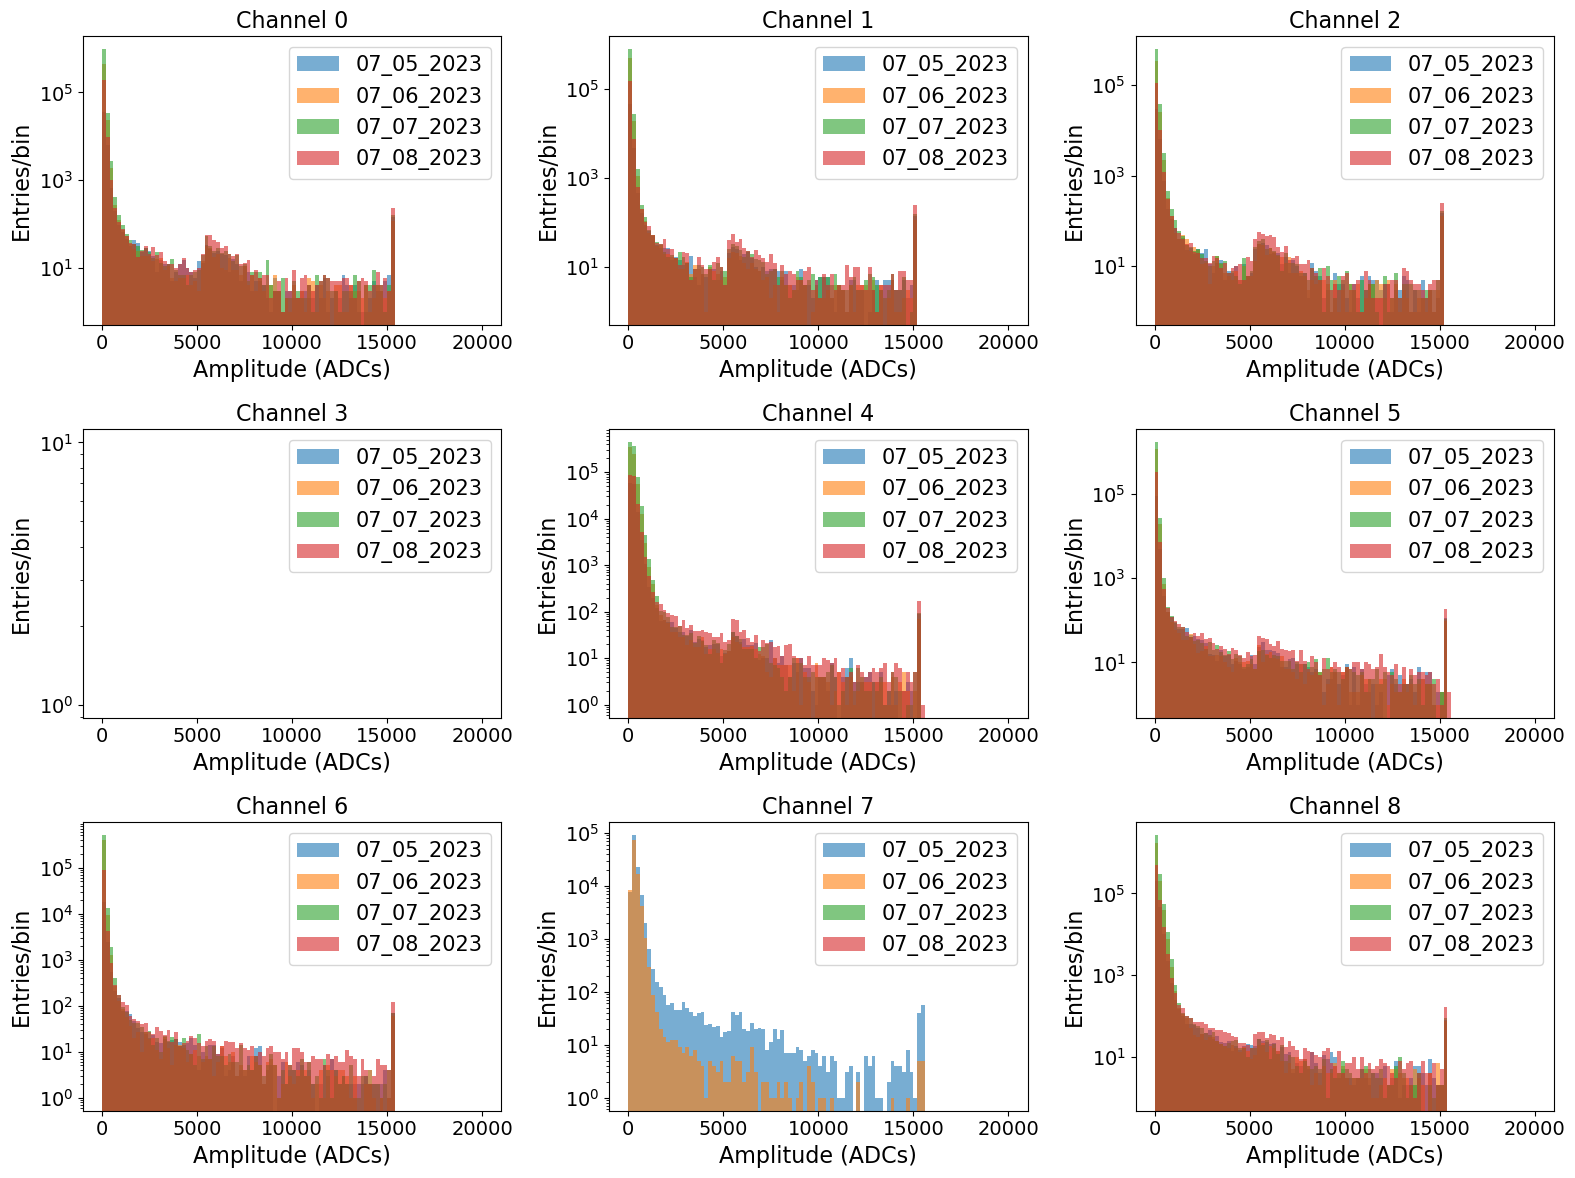

In [26]:
print('')
print('                      ---------------------------------------')
print('                      -- 0.2 ppm XENON (high light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '07_05_2023'
select_date2 = '07_06_2023'
select_date3 = '07_07_2023'
select_date4 = '07_08_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date1][k], bins=100, range=(0,20000), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date2][k], bins=100, range=(0,20000), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date3][k], bins=100, range=(0,20000), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date4][k], bins=100, range=(0,20000), log=True, label=f'{select_date4}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()

## Compare the different amount of Xenon:


                      ---------------------------------------
                      -- Height of peaks (low light levels) -
                      ---------------------------------------



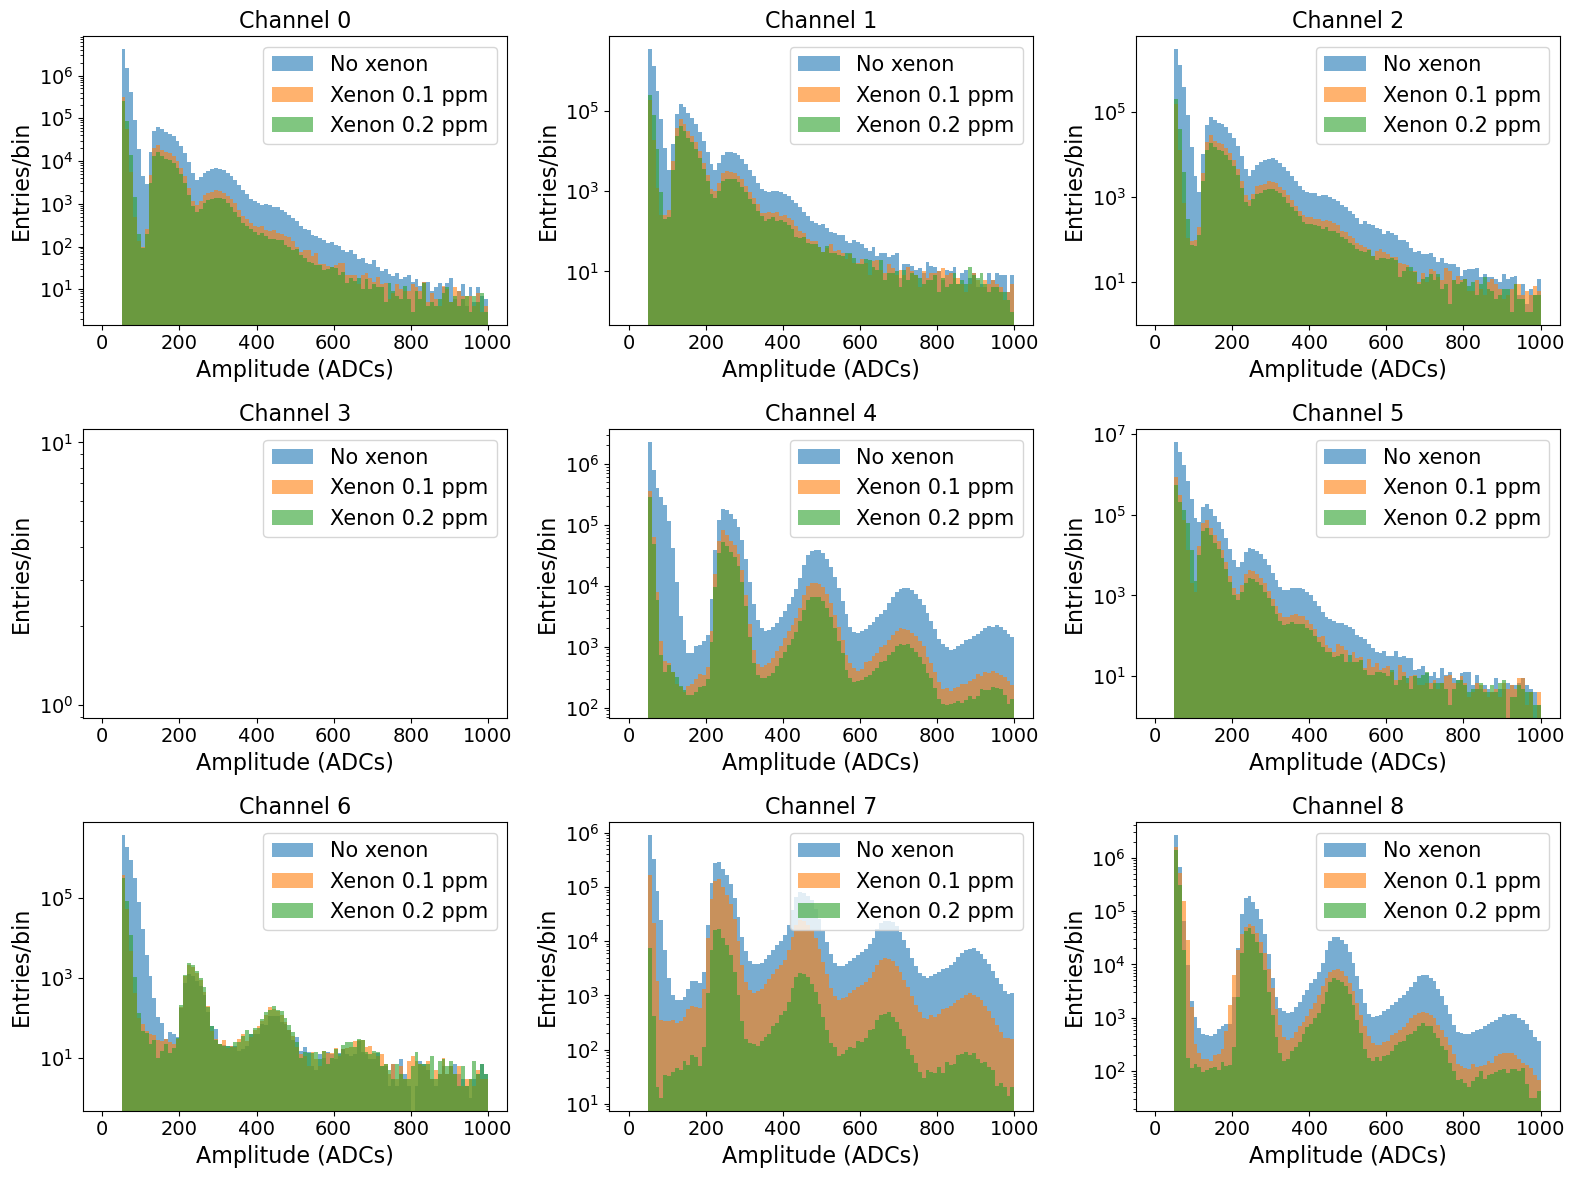

In [27]:
print('')
print('                      ---------------------------------------')
print('                      -- Height of peaks (low light levels) -')
print('                      ---------------------------------------')
print('')

select_date1 = '05_30_2023'
select_date2 = '06_20_2023'
select_date3 = '07_06_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date1][k], bins=100, range=(0,1000), log=True, label=f'No xenon', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date2][k], bins=100, range=(0,1000), log=True, label=f'Xenon 0.1 ppm', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date3][k], bins=100, range=(0,1000), log=True, label=f'Xenon 0.2 ppm', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      - Height of peaks (high light levels) -
                      ---------------------------------------



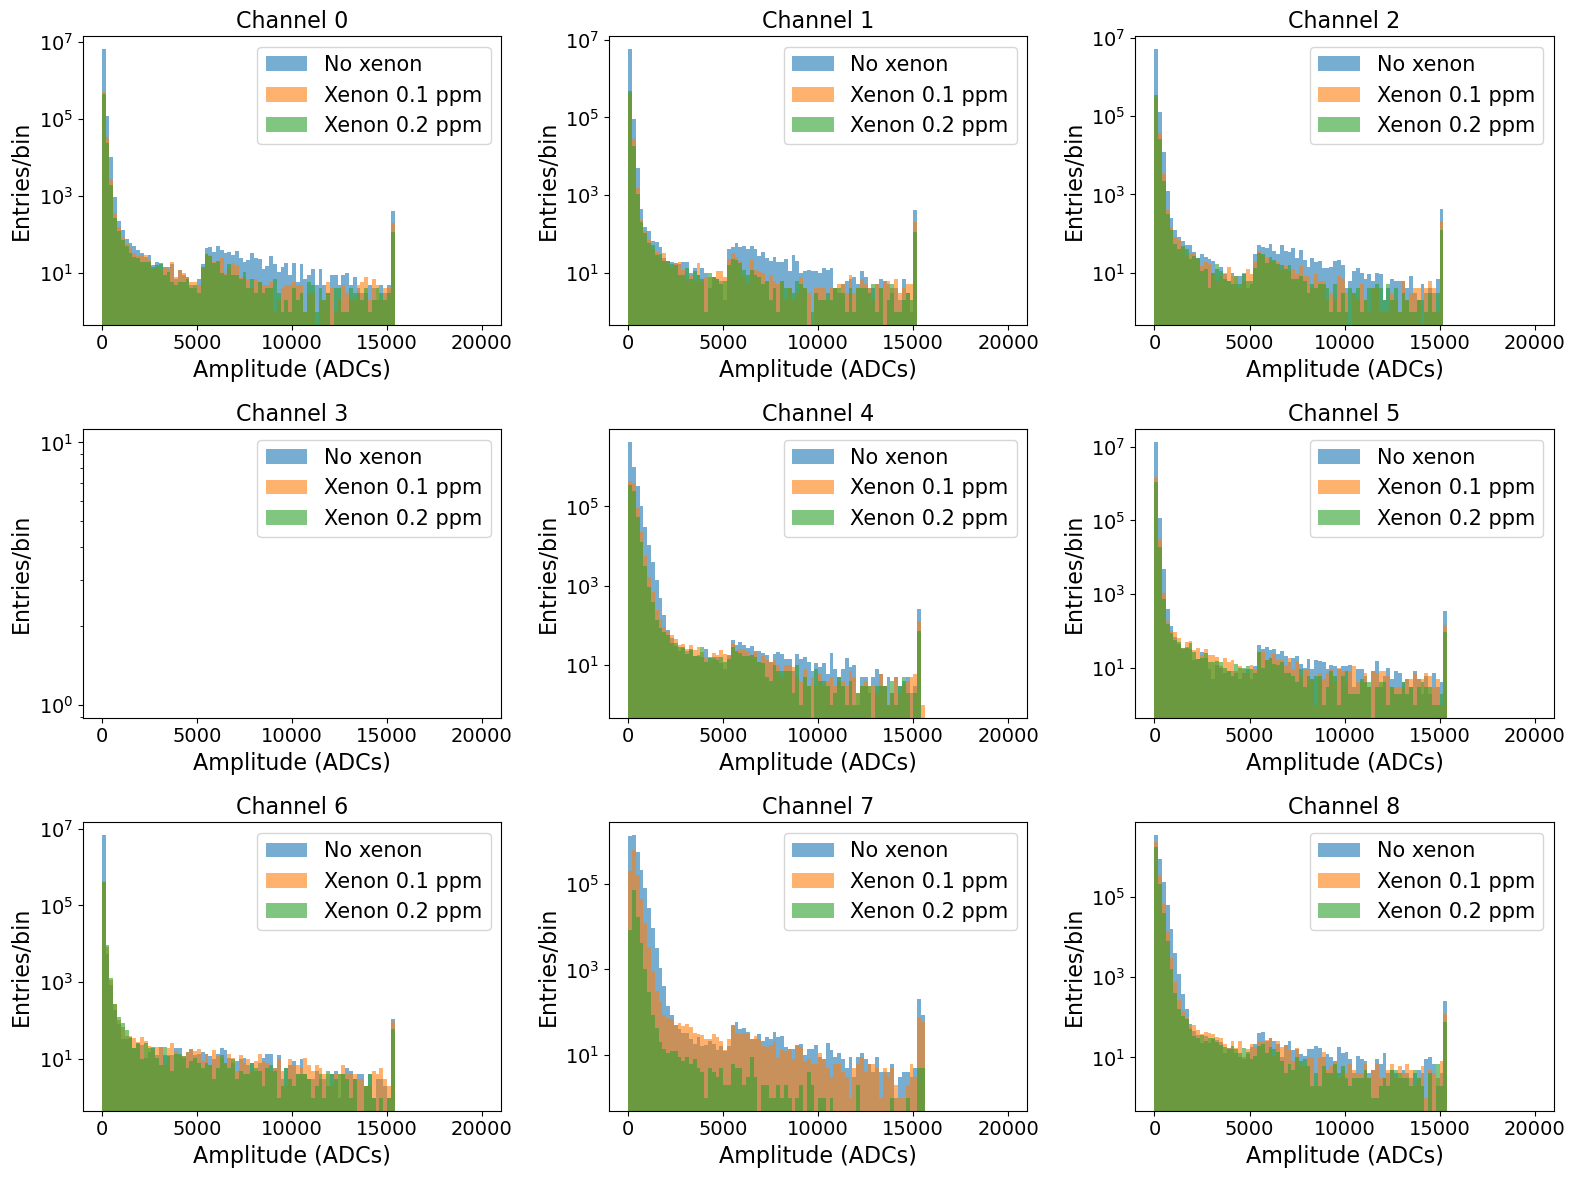

In [28]:
print('')
print('                      ---------------------------------------')
print('                      - Height of peaks (high light levels) -')
print('                      ---------------------------------------')
print('')

select_date1 = '05_30_2023'
select_date2 = '06_20_2023'
select_date3 = '07_06_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date1][k], bins=100, range=(0,20000), log=True, label=f'No xenon', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date2][k], bins=100, range=(0,20000), log=True, label=f'Xenon 0.1 ppm', alpha=0.6)
    axs[i][j].hist(peak_heigh_all_channels_dict[select_date3][k], bins=100, range=(0,20000), log=True, label=f'Xenon 0.2 ppm', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()

## Integration of peaks until the wf reaches negative values


                      ---------------------------------------
                      ----- No XENON (high light levels) ----
                      ---------------------------------------



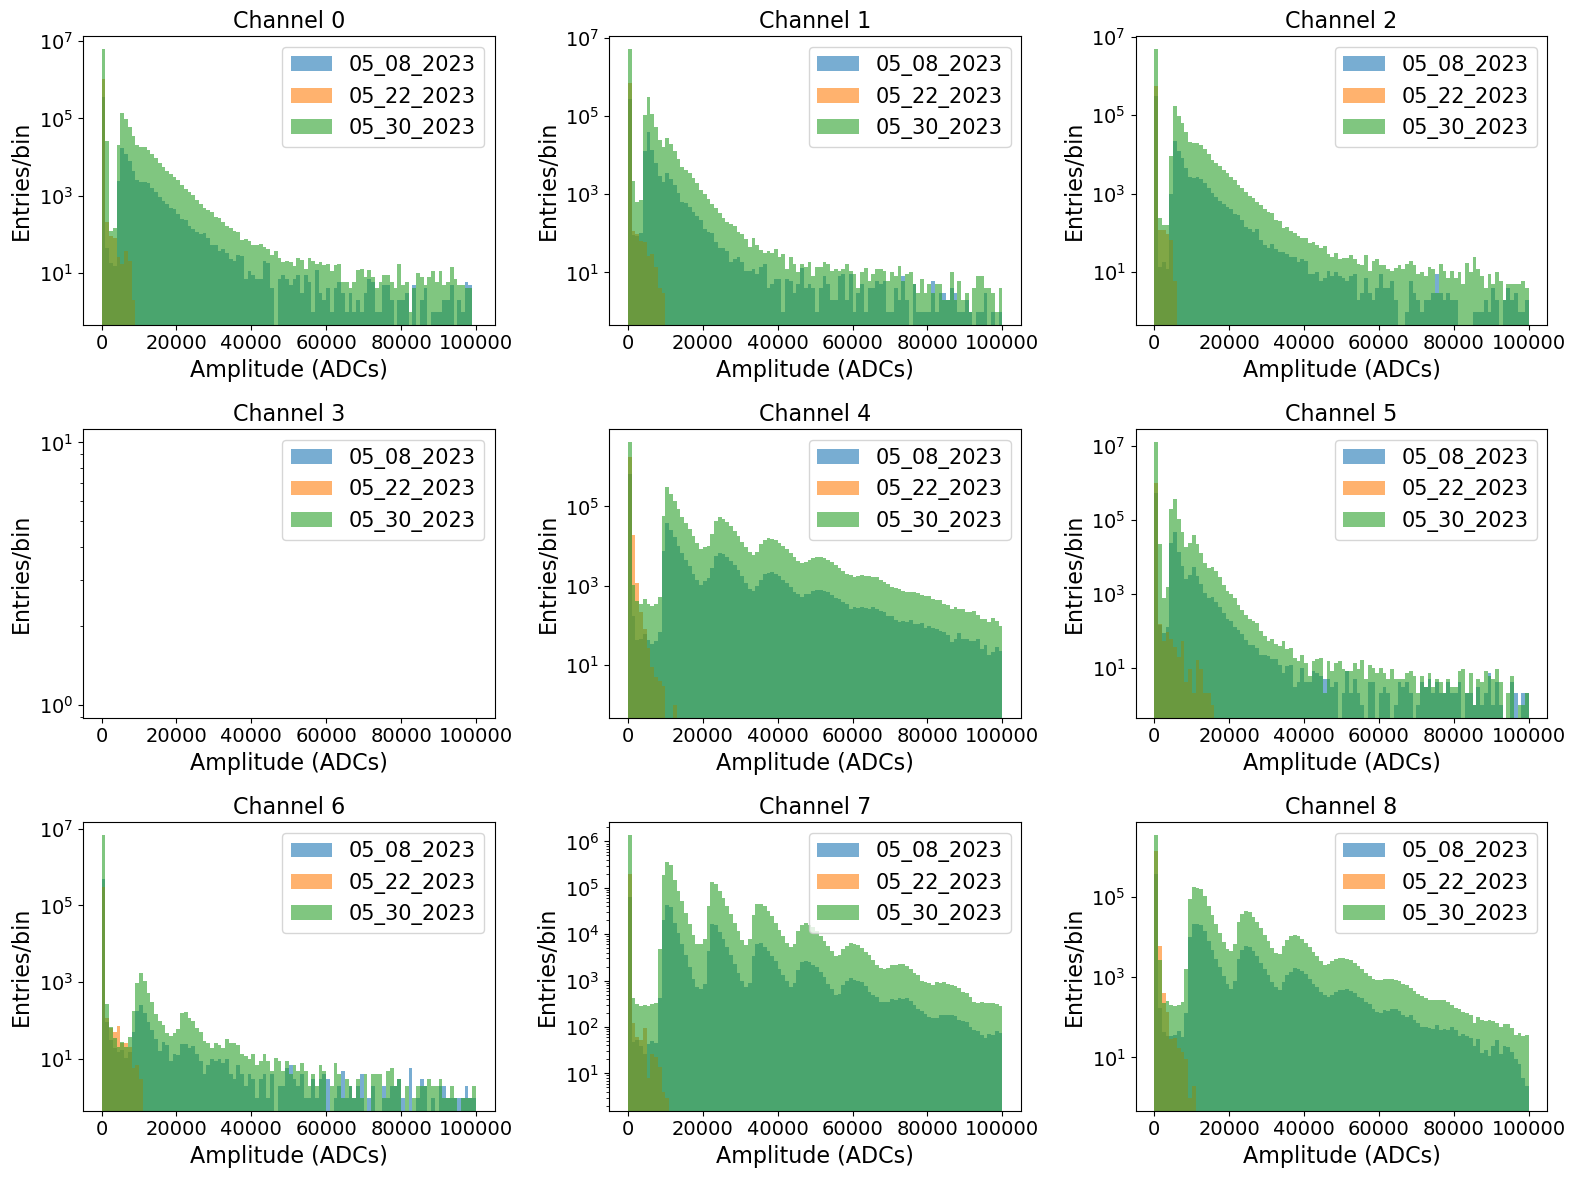

In [29]:
print('')
print('                      ---------------------------------------')
print('                      ----- No XENON (high light levels) ----')
print('                      ---------------------------------------')
print('')

select_date1 = '05_08_2023'
select_date2 = '05_22_2023'
select_date3 = '05_30_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_all_channels_dict[select_date1][k], bins=100, range=(0,100000), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date2][k], bins=100, range=(0,100000), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date3][k], bins=100, range=(0,100000), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      -- 0.1 ppm XENON (high light levels) --
                      ---------------------------------------



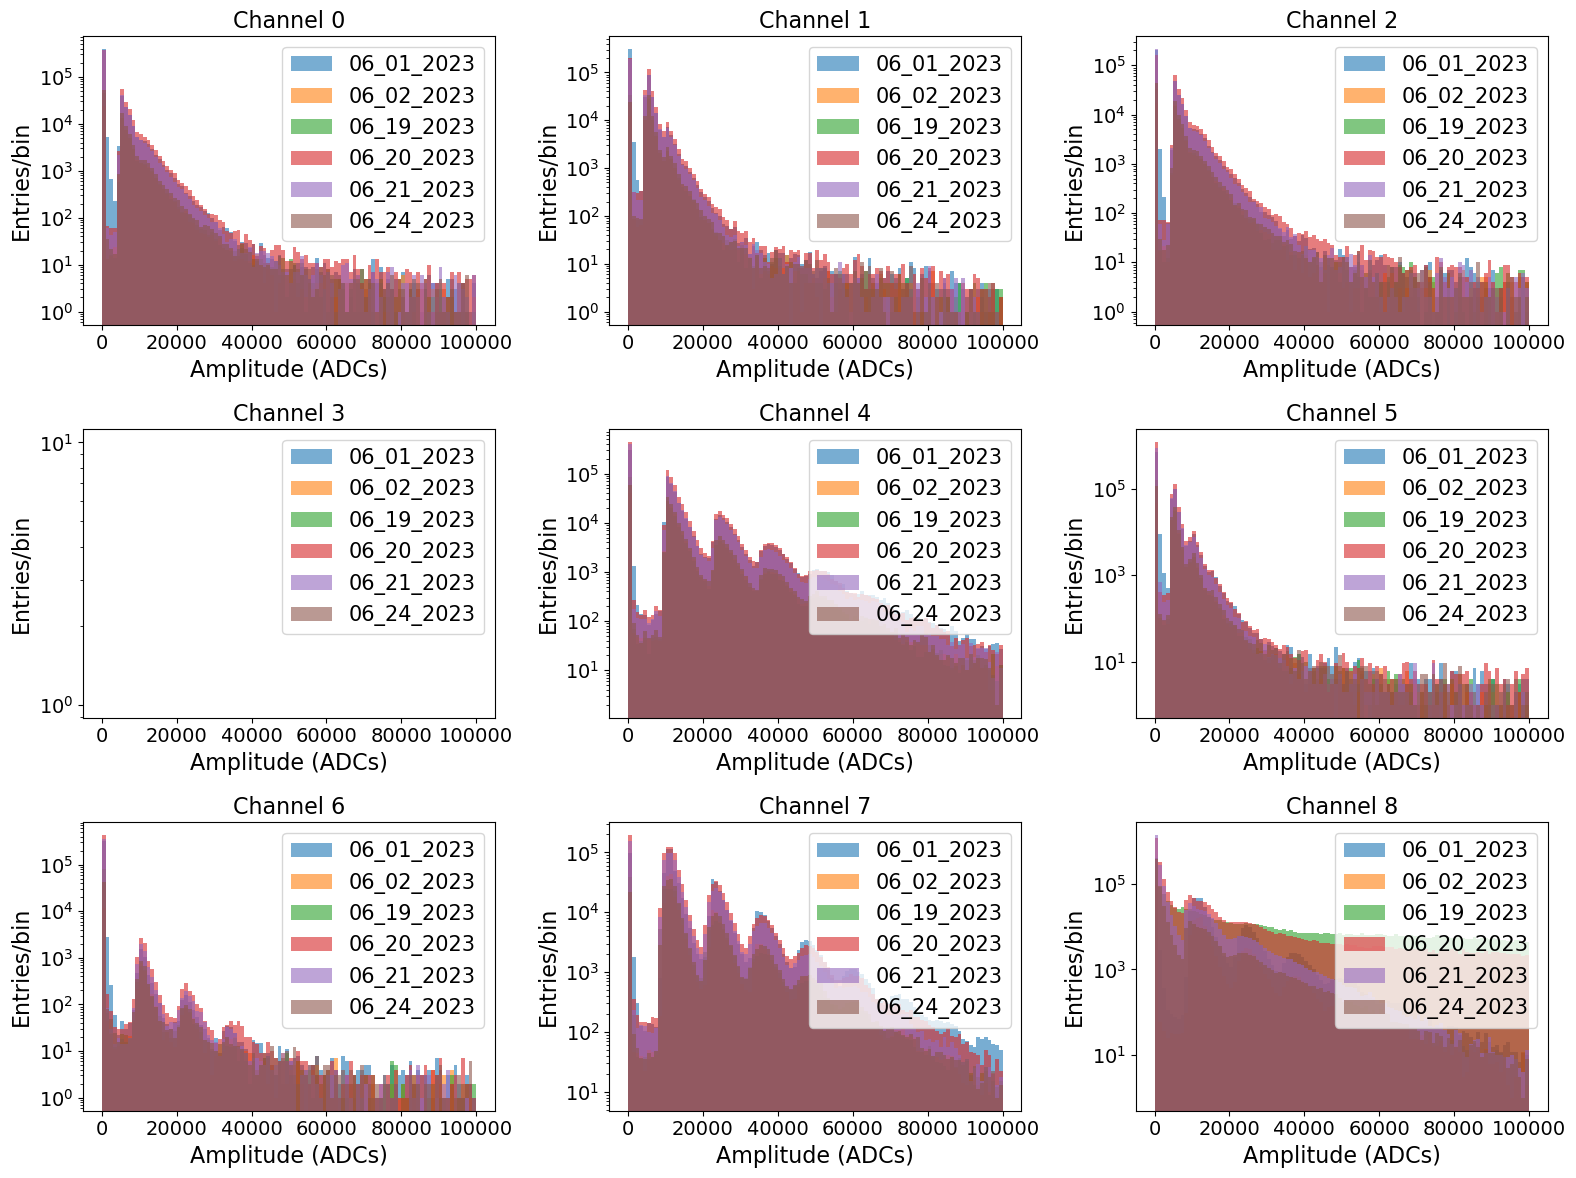

In [30]:
print('')
print('                      ---------------------------------------')
print('                      -- 0.1 ppm XENON (high light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '06_01_2023'
select_date2 = '06_02_2023'
select_date3 = '06_19_2023'
select_date4 = '06_20_2023'
select_date5 = '06_21_2023'
select_date6 = '06_24_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_all_channels_dict[select_date1][k], bins=100, range=(0,100000), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date2][k], bins=100, range=(0,100000), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date3][k], bins=100, range=(0,100000), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date4][k], bins=100, range=(0,100000), log=True, label=f'{select_date4}', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date5][k], bins=100, range=(0,100000), log=True, label=f'{select_date5}', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date6][k], bins=100, range=(0,100000), log=True, label=f'{select_date6}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      -- 0.2 ppm XENON (high light levels) --
                      ---------------------------------------



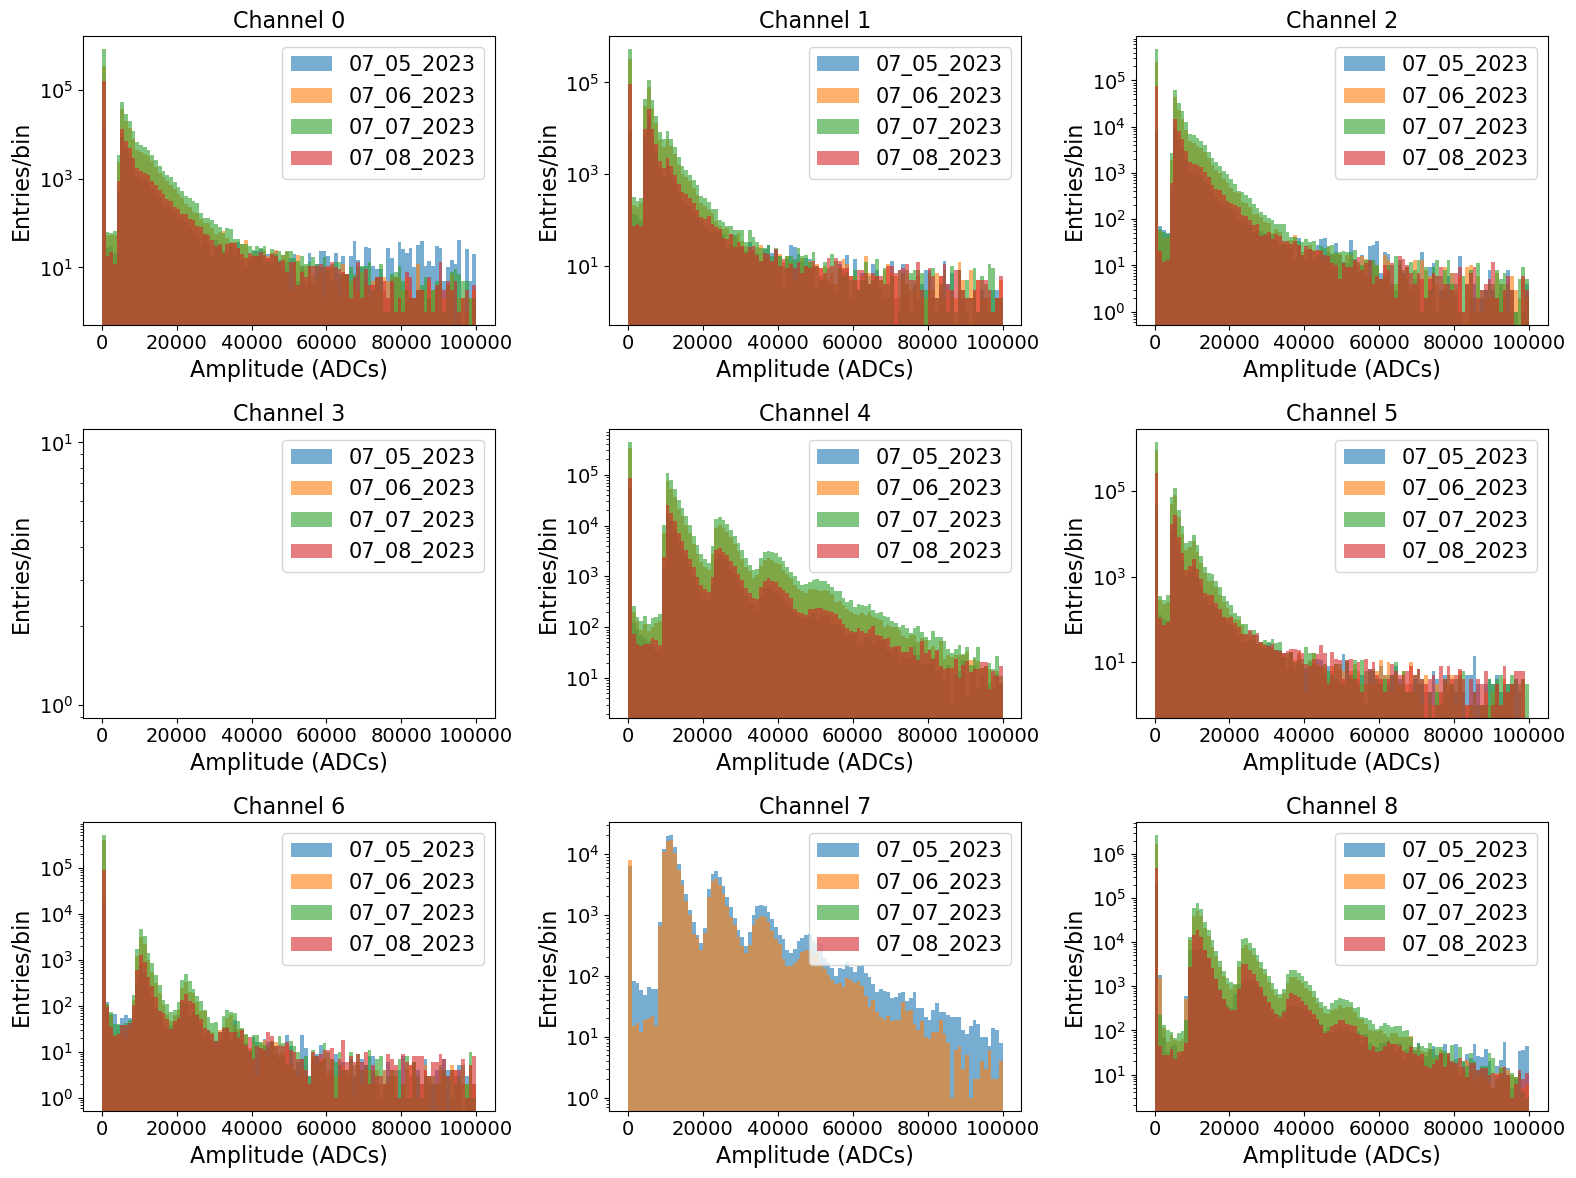

In [31]:
print('')
print('                      ---------------------------------------')
print('                      -- 0.2 ppm XENON (high light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '07_05_2023'
select_date2 = '07_06_2023'
select_date3 = '07_07_2023'
select_date4 = '07_08_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_all_channels_dict[select_date1][k], bins=100, range=(0,100000), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date2][k], bins=100, range=(0,100000), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date3][k], bins=100, range=(0,100000), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date4][k], bins=100, range=(0,100000), log=True, label=f'{select_date4}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()

## Compare the different amount of Xenon


                      ---------------------------------------
                      --- Peak integ 1 (high light levels) --
                      ---------------------------------------



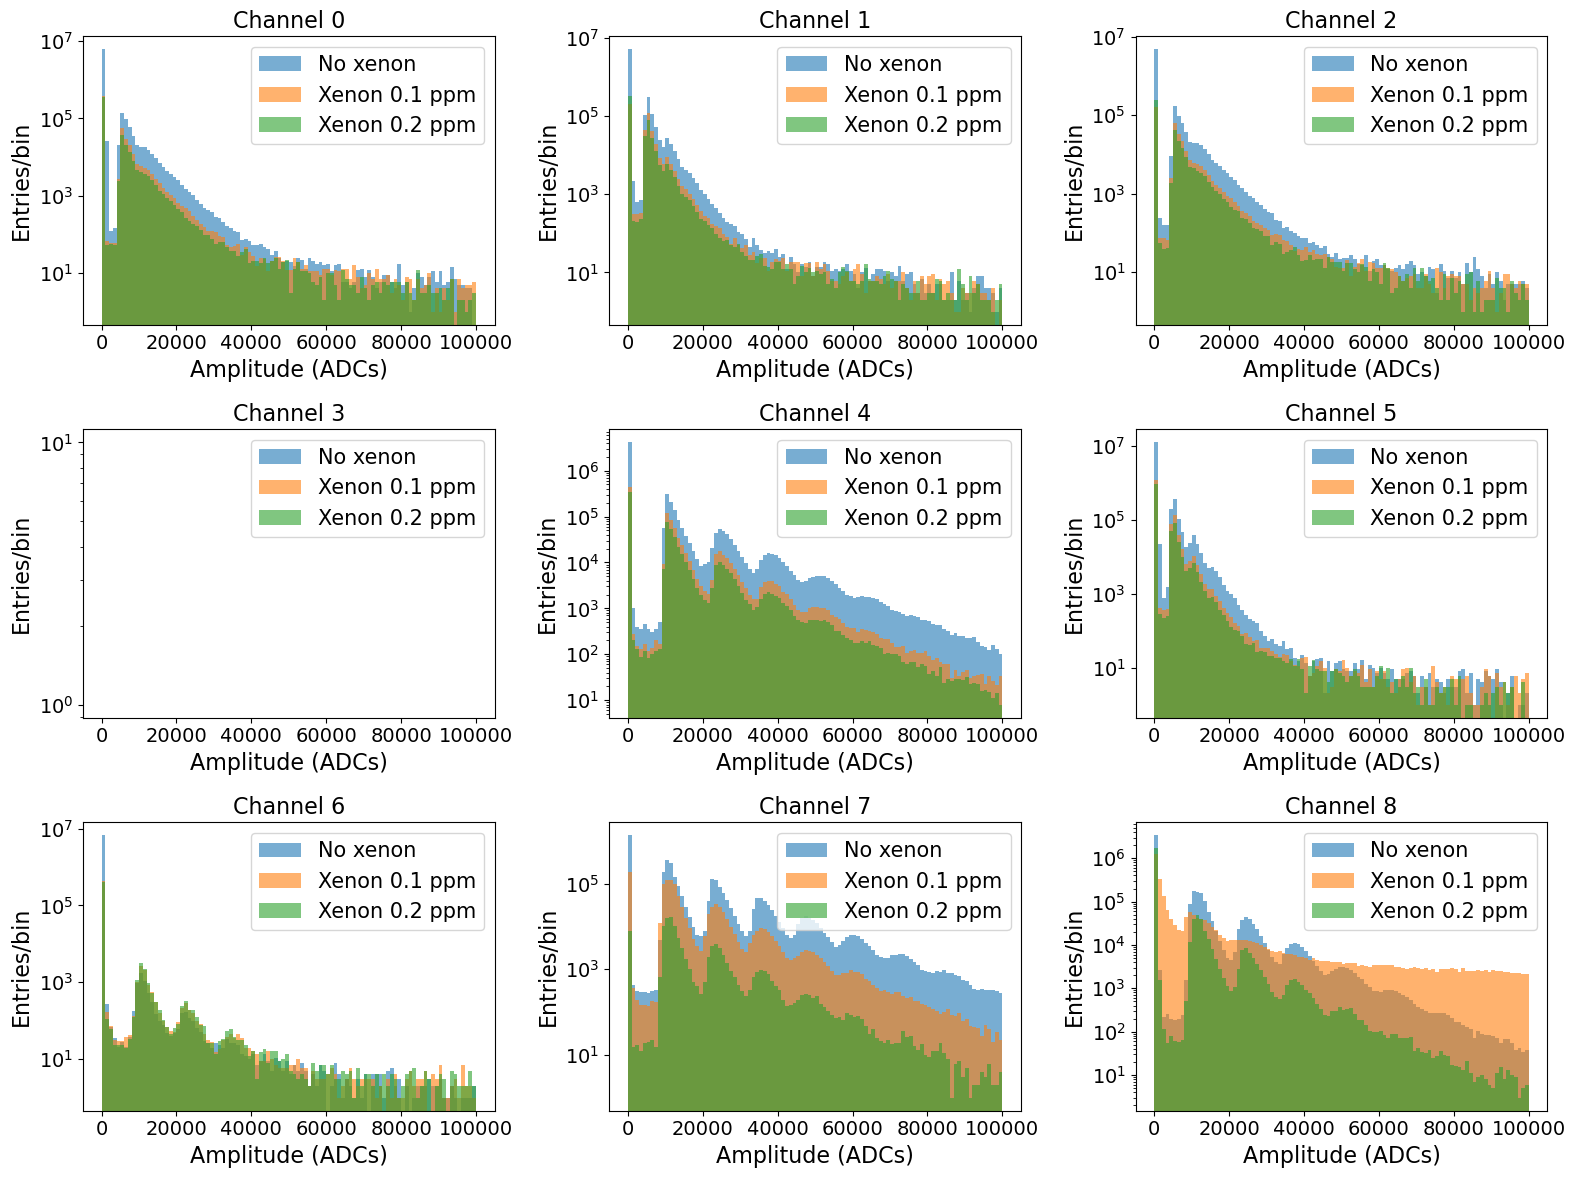

In [32]:
print('')
print('                      ---------------------------------------')
print('                      --- Peak integ 1 (high light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '05_30_2023'
select_date2 = '06_20_2023'
select_date3 = '07_06_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_all_channels_dict[select_date1][k], bins=100, range=(0,100000), log=True, label=f'No xenon', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date2][k], bins=100, range=(0,100000), log=True, label=f'Xenon 0.1 ppm', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date3][k], bins=100, range=(0,100000), log=True, label=f'Xenon 0.2 ppm', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      --- Peak integ 1 (high light levels) --
                      ---------------------------------------



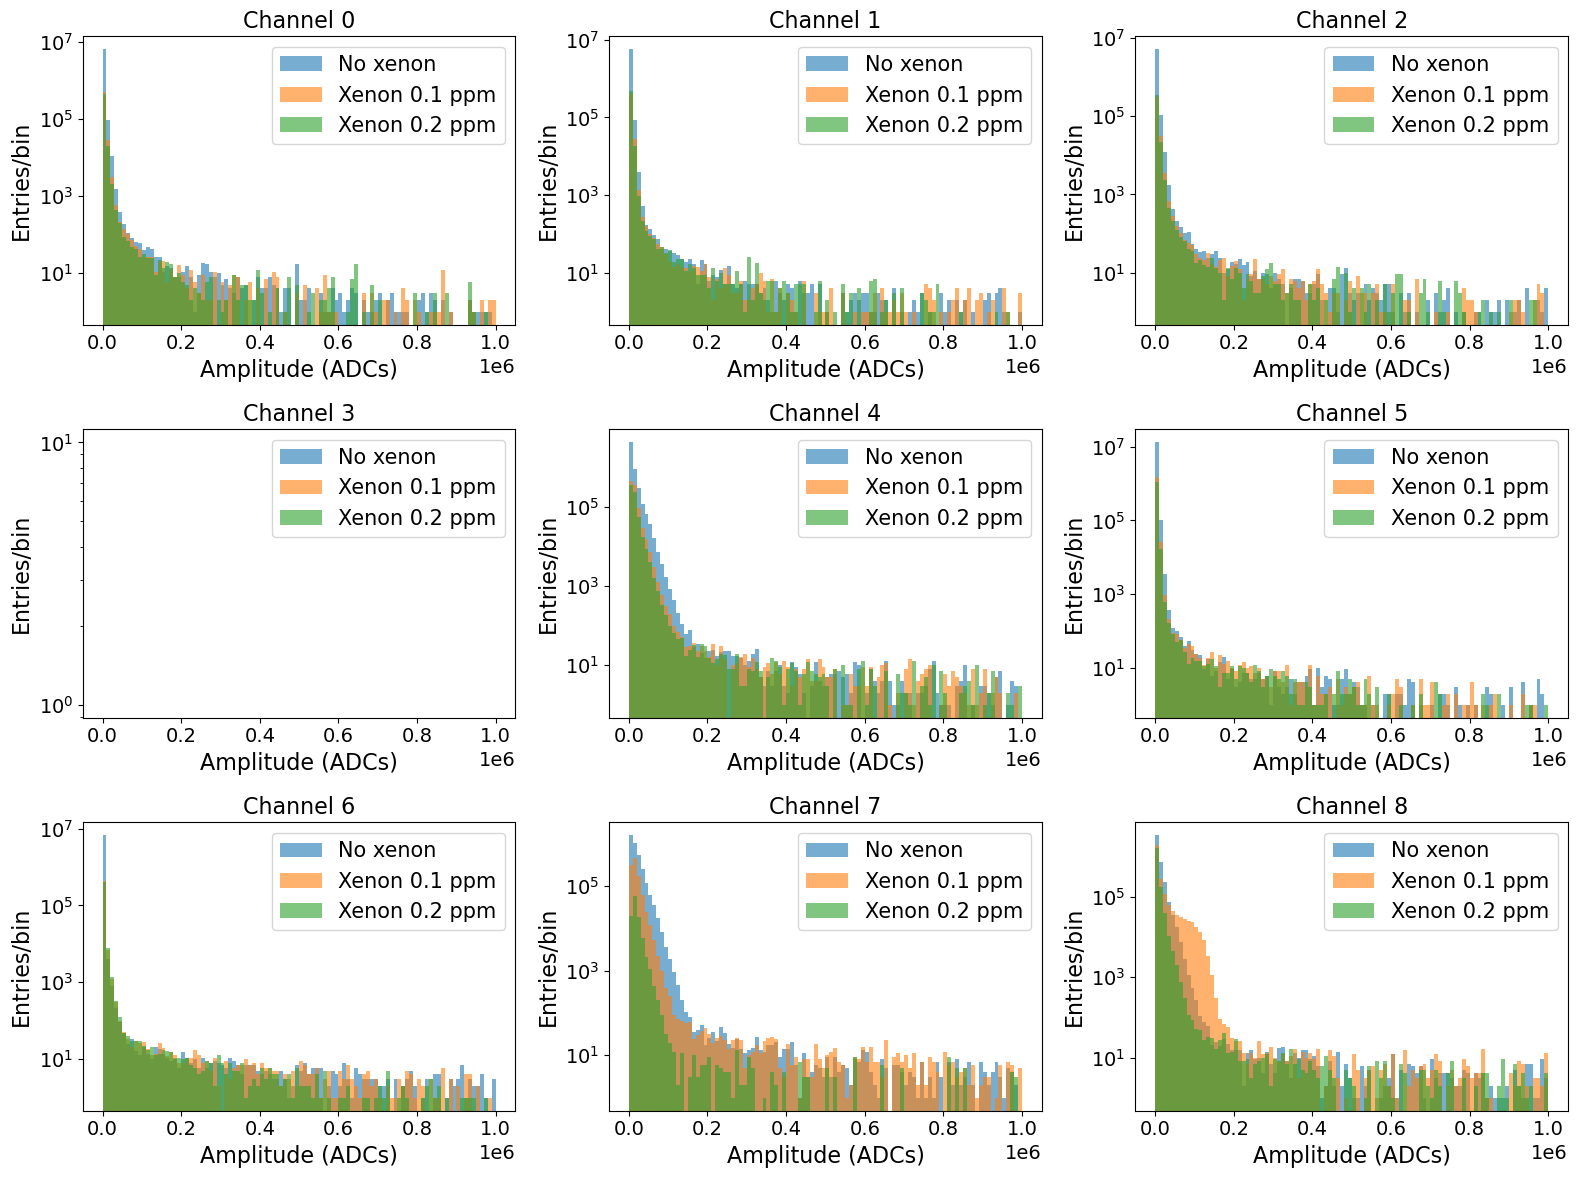

In [33]:
print('')
print('                      ---------------------------------------')
print('                      --- Peak integ 1 (high light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '05_30_2023'
select_date2 = '06_20_2023'
select_date3 = '07_06_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_all_channels_dict[select_date1][k], bins=100, range=(0,1000000), log=True, label=f'No xenon', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date2][k], bins=100, range=(0,1000000), log=True, label=f'Xenon 0.1 ppm', alpha=0.6)
    axs[i][j].hist(peak_area_all_channels_dict[select_date3][k], bins=100, range=(0,1000000), log=True, label=f'Xenon 0.2 ppm', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()

## Integration of peaks with Zero Suppression


                      ---------------------------------------
                      ----- No XENON (low light levels) -----
                      ---------------------------------------



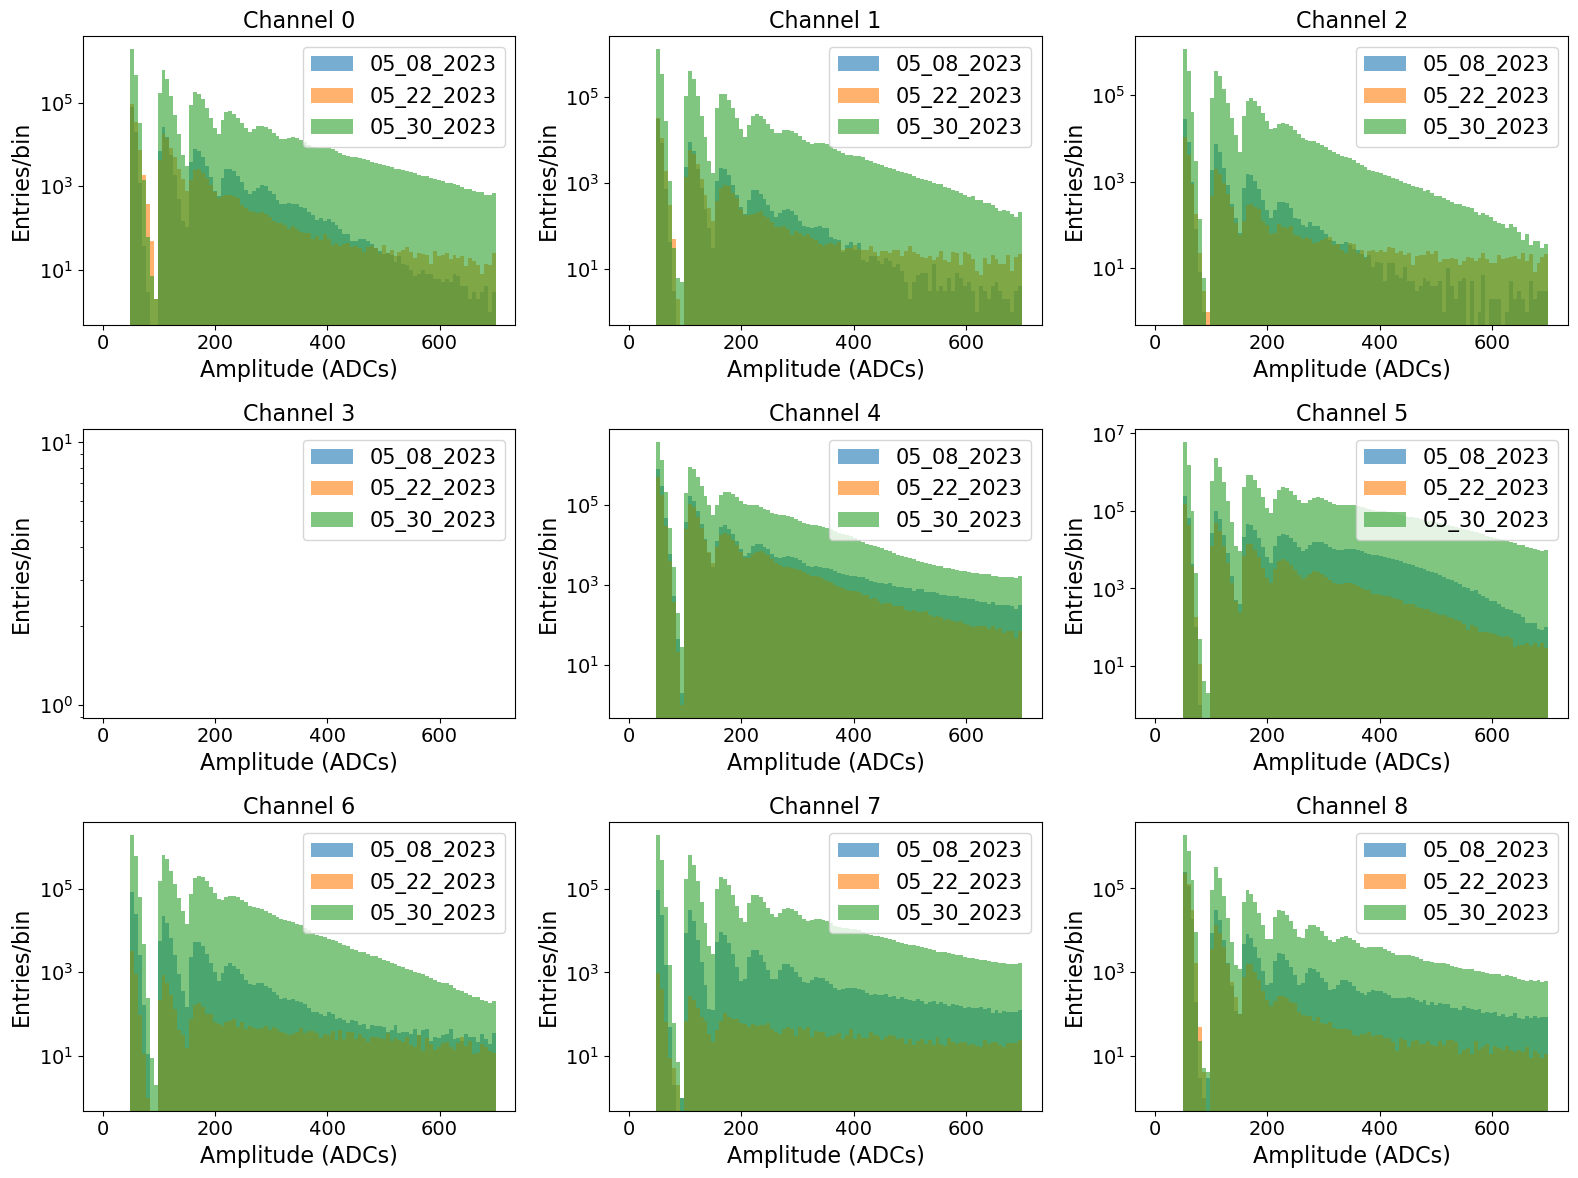

In [34]:
print('')
print('                      ---------------------------------------')
print('                      ----- No XENON (low light levels) -----')
print('                      ---------------------------------------')
print('')

select_date1 = '05_08_2023'
select_date2 = '05_22_2023'
select_date3 = '05_30_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date1][k], bins=100, range=(0,700), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date2][k], bins=100, range=(0,700), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date3][k], bins=100, range=(0,700), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      ----- No XENON (high light levels) ----
                      ---------------------------------------



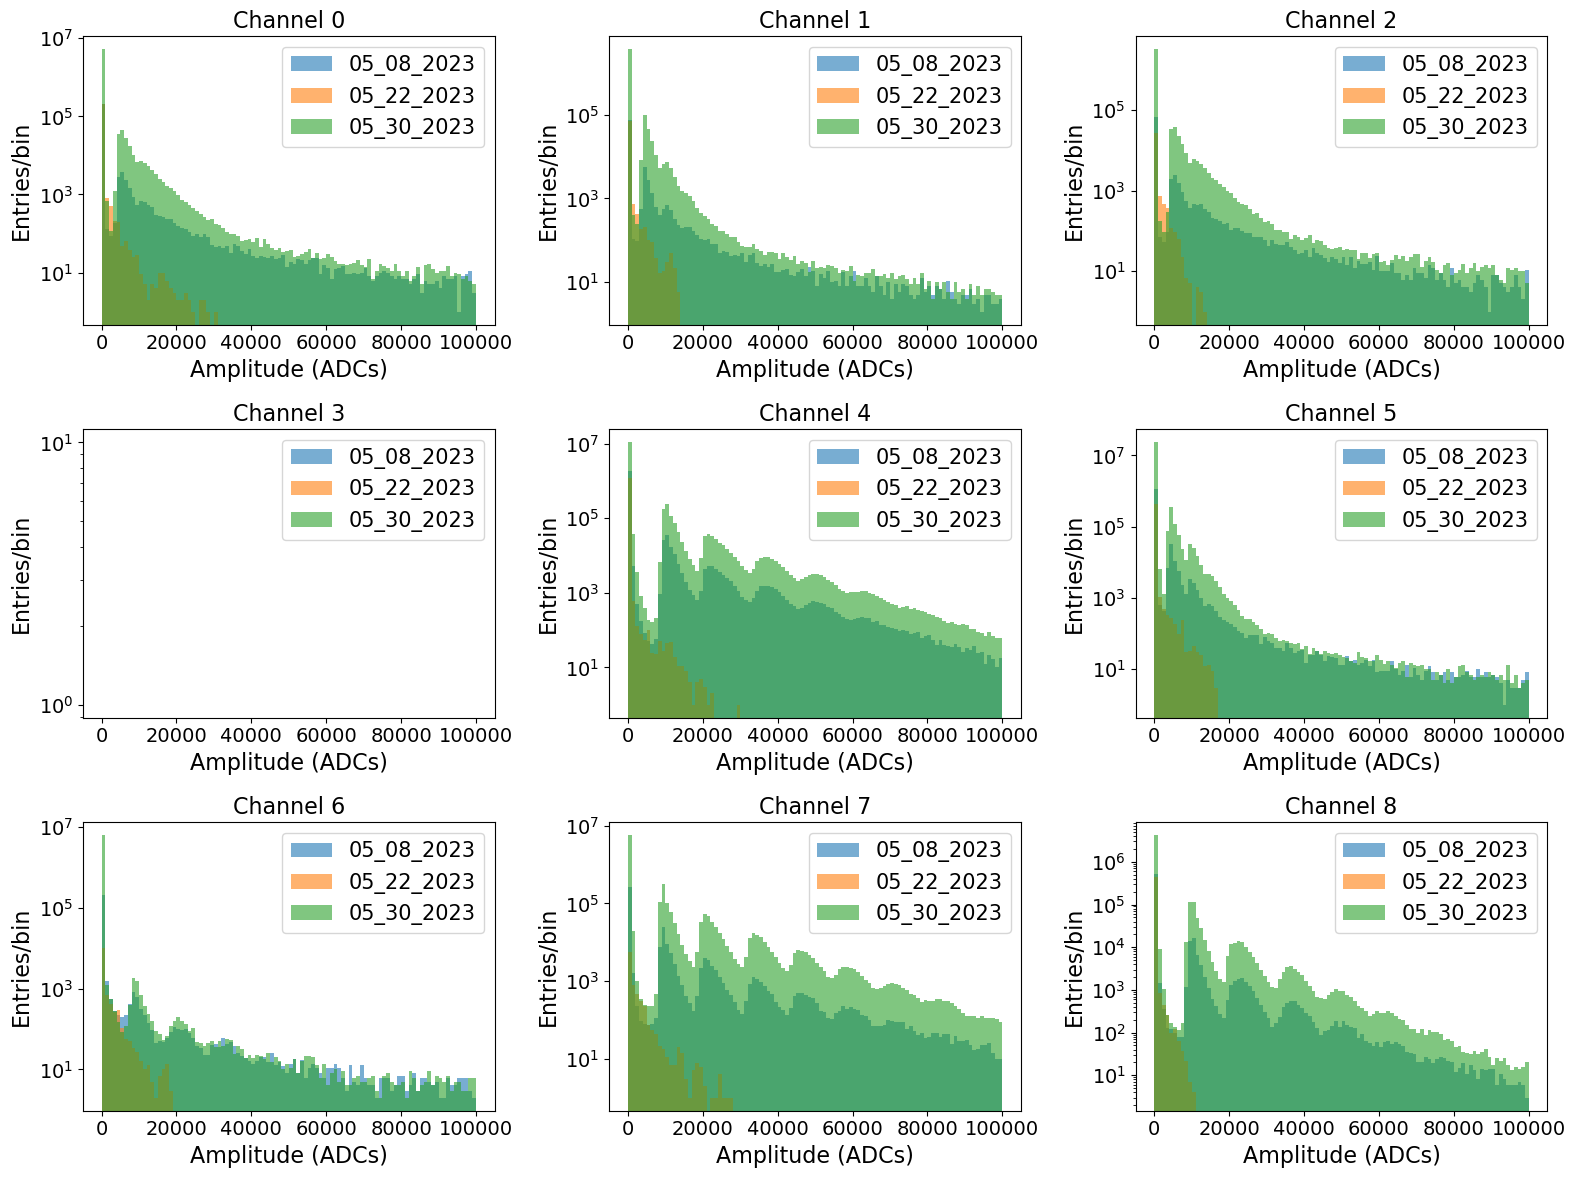

In [35]:
print('')
print('                      ---------------------------------------')
print('                      ----- No XENON (high light levels) ----')
print('                      ---------------------------------------')
print('')

select_date1 = '05_08_2023'
select_date2 = '05_22_2023'
select_date3 = '05_30_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date1][k], bins=100, range=(0,100000), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date2][k], bins=100, range=(0,100000), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date3][k], bins=100, range=(0,100000), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      --- 0.1 ppm XENON (low light levels) --
                      ---------------------------------------



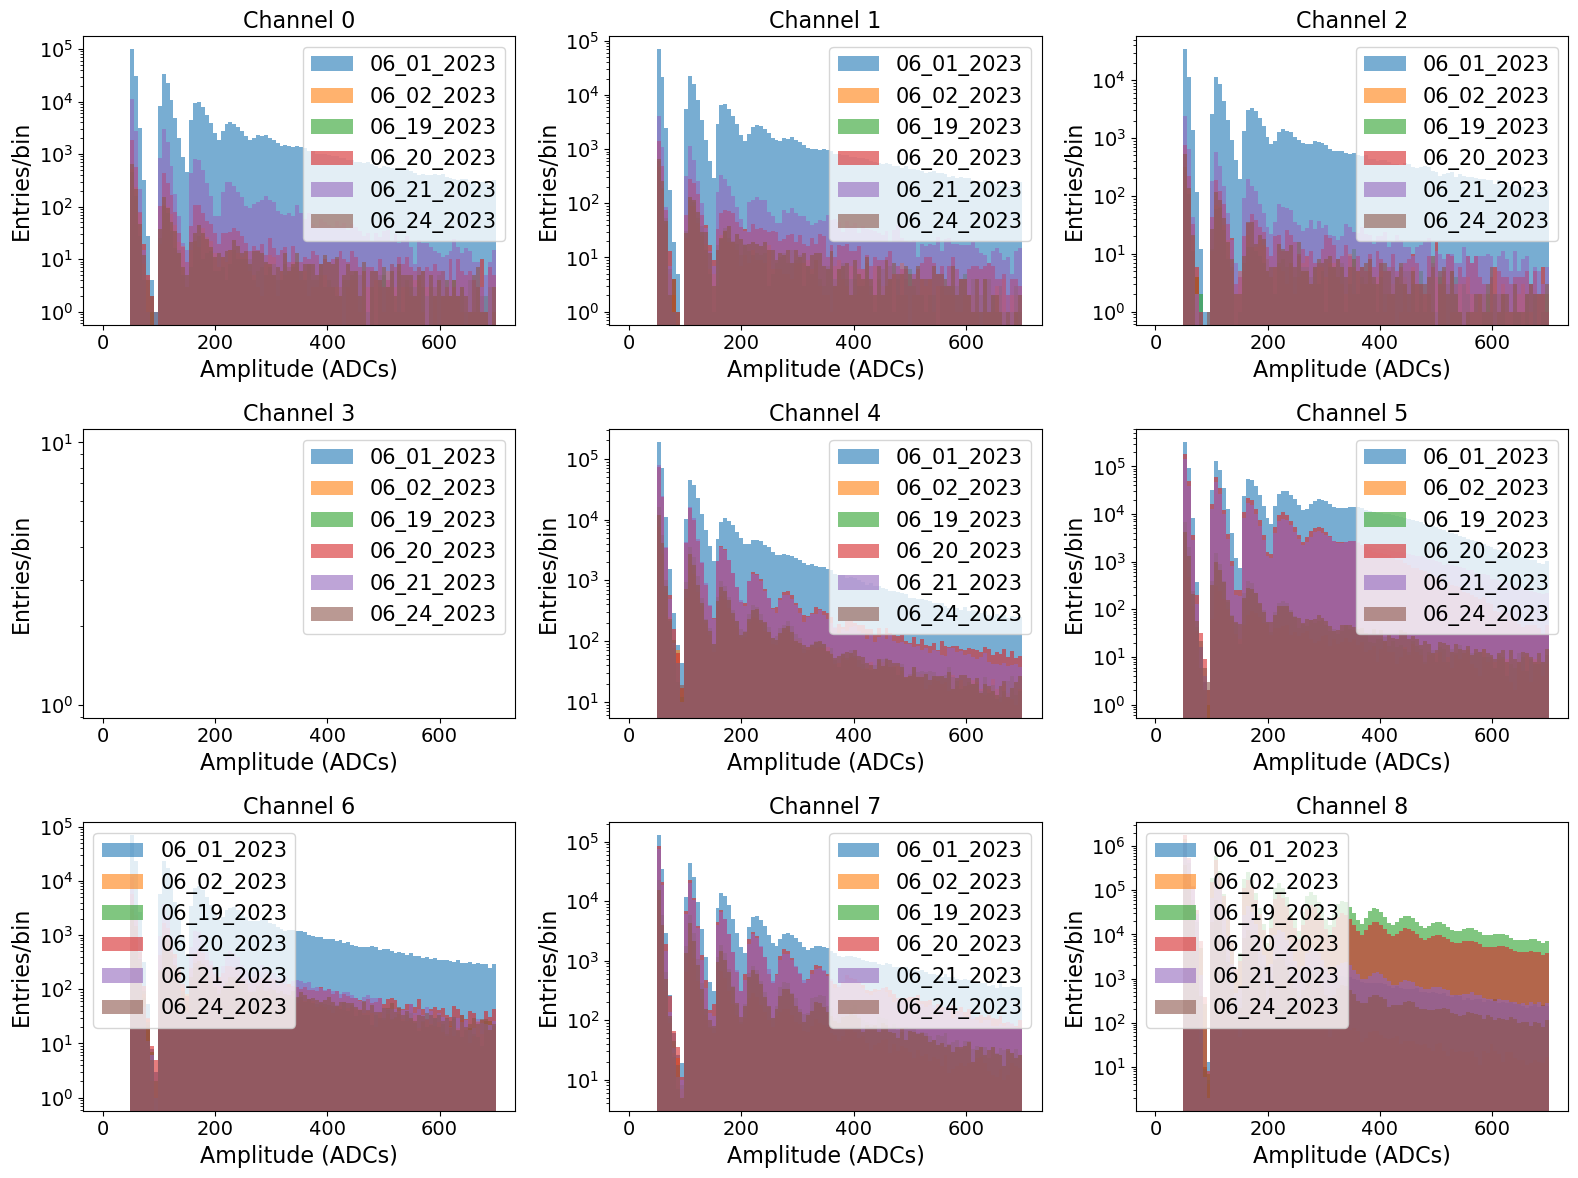

In [36]:
print('')
print('                      ---------------------------------------')
print('                      --- 0.1 ppm XENON (low light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '06_01_2023'
select_date2 = '06_02_2023'
select_date3 = '06_19_2023'
select_date4 = '06_20_2023'
select_date5 = '06_21_2023'
select_date6 = '06_24_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date1][k], bins=100, range=(0,700), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date2][k], bins=100, range=(0,700), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date3][k], bins=100, range=(0,700), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date4][k], bins=100, range=(0,700), log=True, label=f'{select_date4}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date5][k], bins=100, range=(0,700), log=True, label=f'{select_date5}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date6][k], bins=100, range=(0,700), log=True, label=f'{select_date6}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      -- 0.1 ppm XENON (high light levels) --
                      ---------------------------------------



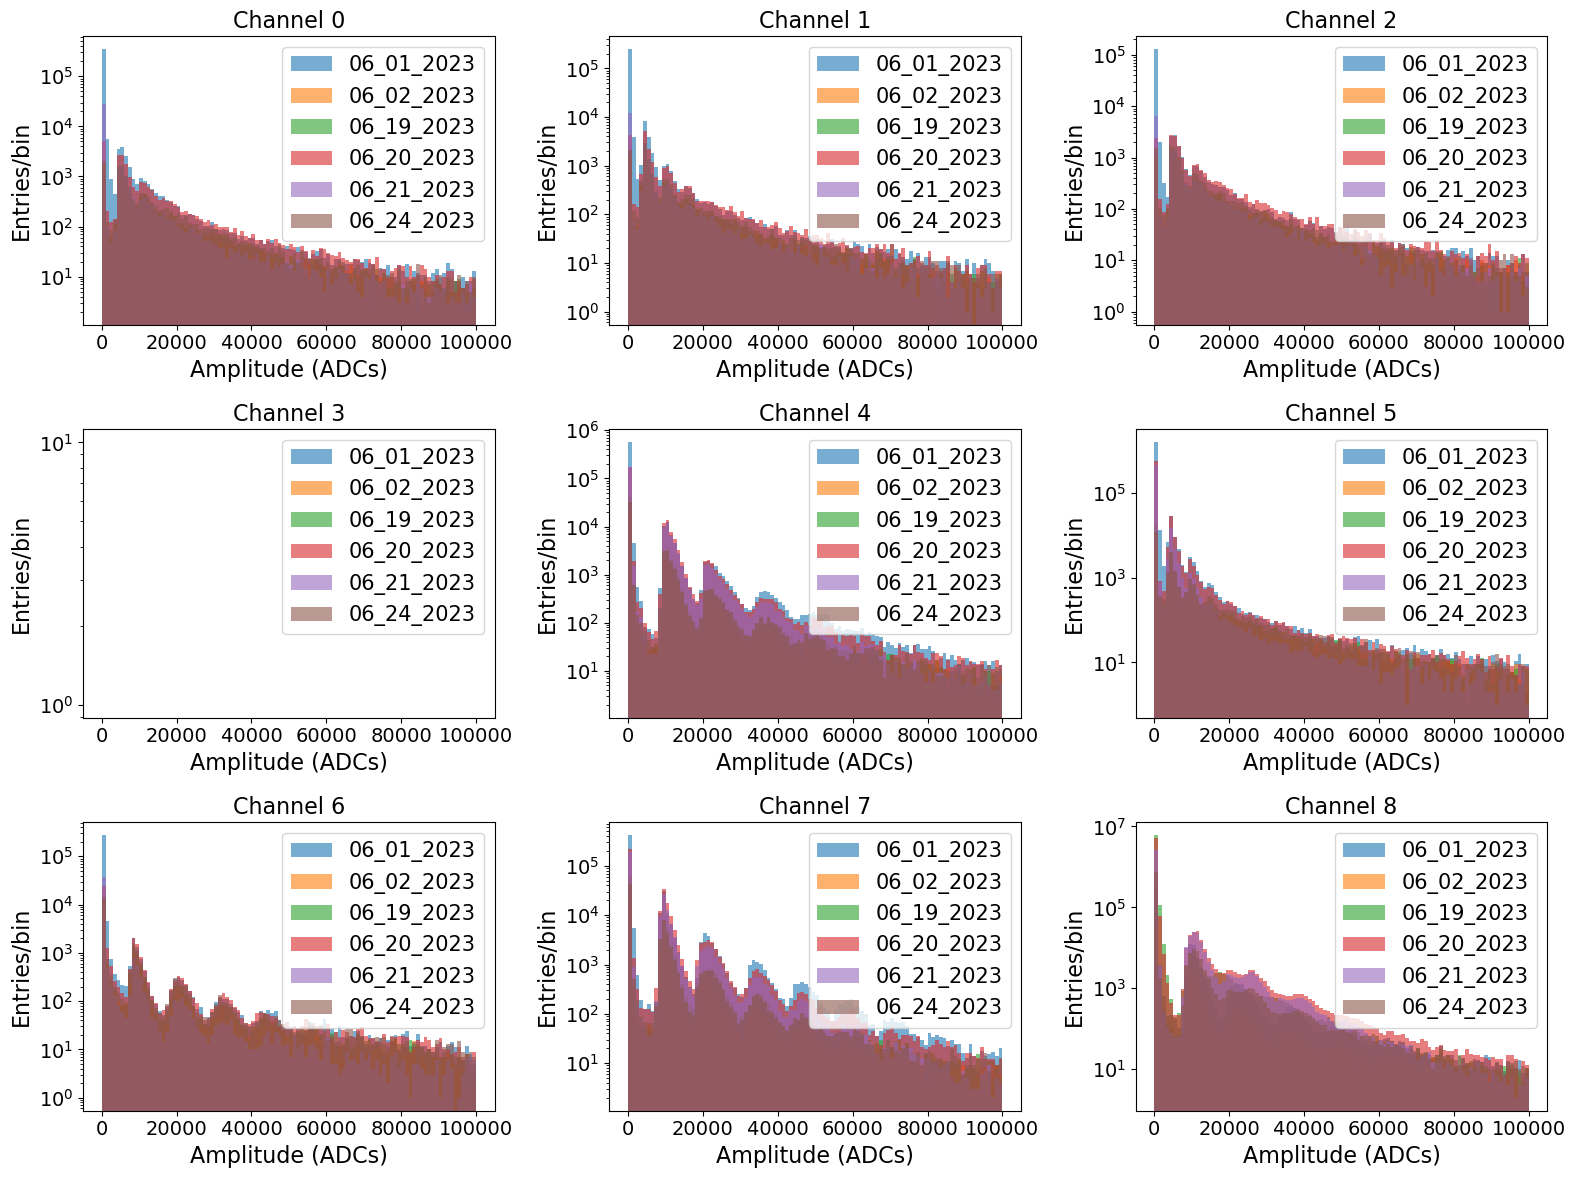

In [37]:
print('')
print('                      ---------------------------------------')
print('                      -- 0.1 ppm XENON (high light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '06_01_2023'
select_date2 = '06_02_2023'
select_date3 = '06_19_2023'
select_date4 = '06_20_2023'
select_date5 = '06_21_2023'
select_date6 = '06_24_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date1][k], bins=100, range=(0,100000), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date2][k], bins=100, range=(0,100000), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date3][k], bins=100, range=(0,100000), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date4][k], bins=100, range=(0,100000), log=True, label=f'{select_date4}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date5][k], bins=100, range=(0,100000), log=True, label=f'{select_date5}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date6][k], bins=100, range=(0,100000), log=True, label=f'{select_date6}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      --- 0.2 ppm XENON (low light levels) --
                      ---------------------------------------



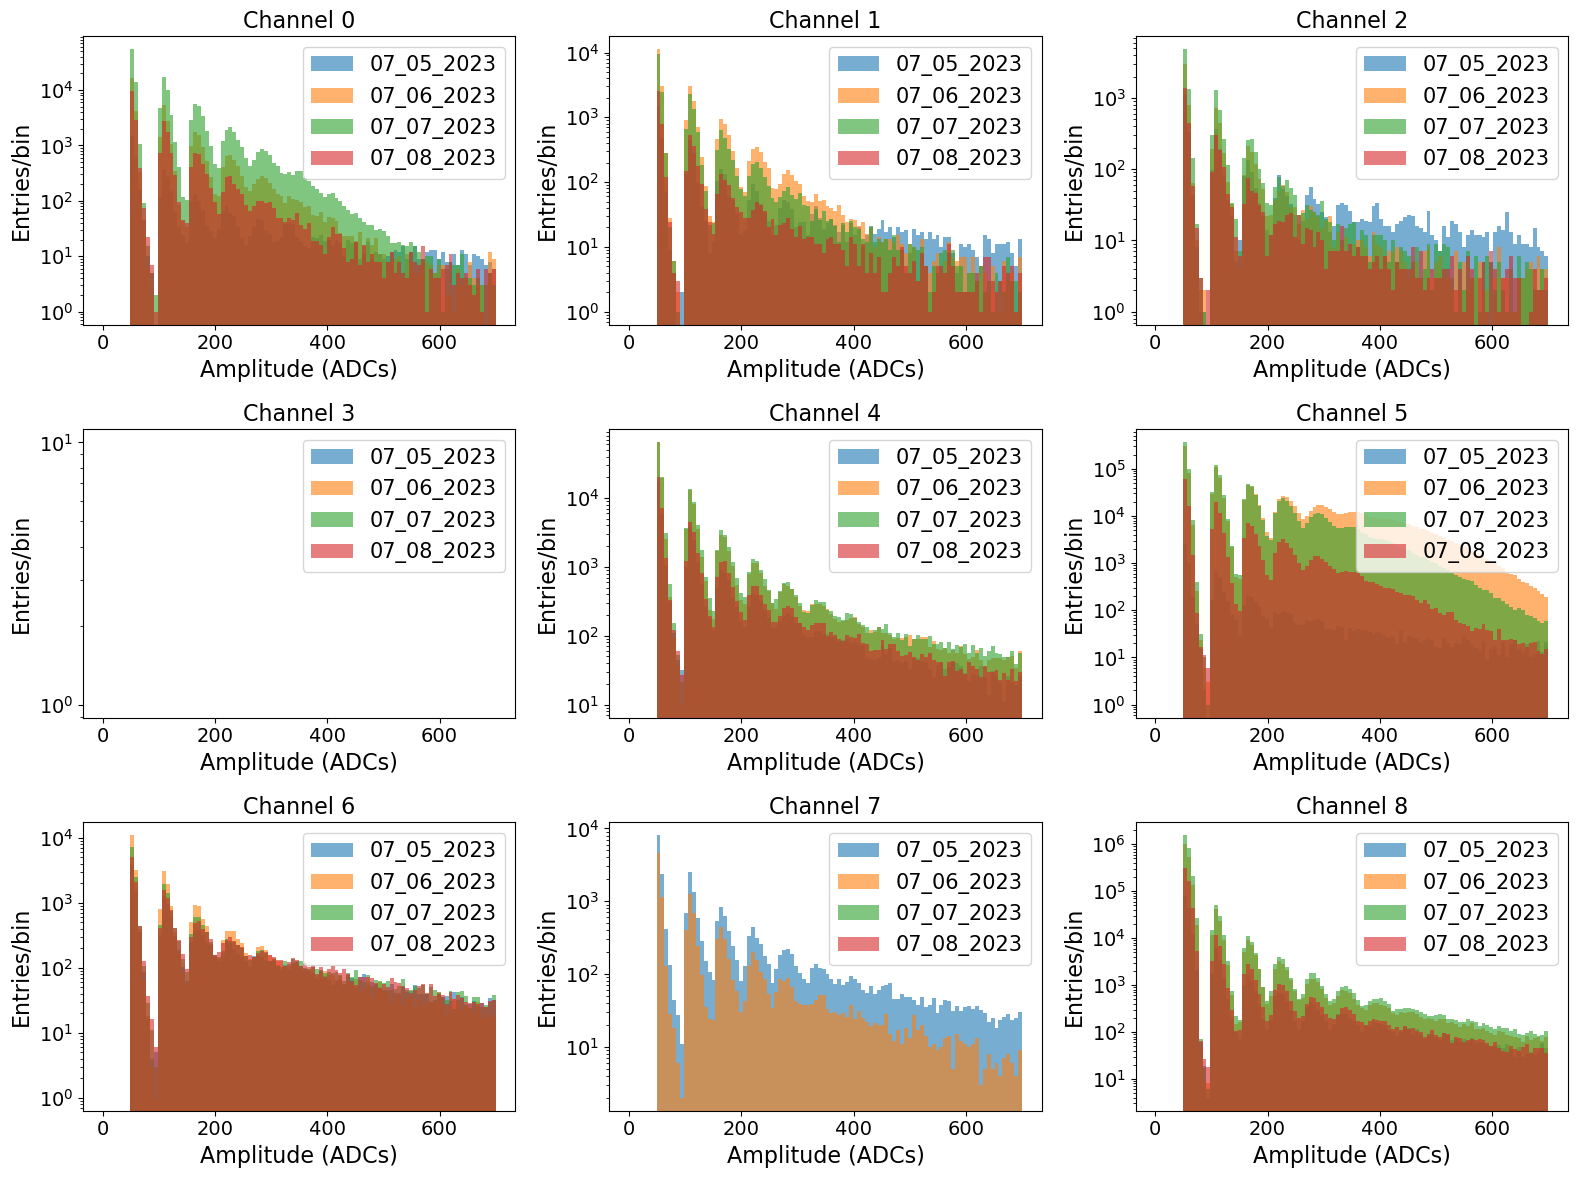

In [38]:
print('')
print('                      ---------------------------------------')
print('                      --- 0.2 ppm XENON (low light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '07_05_2023'
select_date2 = '07_06_2023'
select_date3 = '07_07_2023'
select_date4 = '07_08_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date1][k], bins=100, range=(0,700), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date2][k], bins=100, range=(0,700), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date3][k], bins=100, range=(0,700), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date4][k], bins=100, range=(0,700), log=True, label=f'{select_date4}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      -- 0.2 ppm XENON (high light levels) --
                      ---------------------------------------



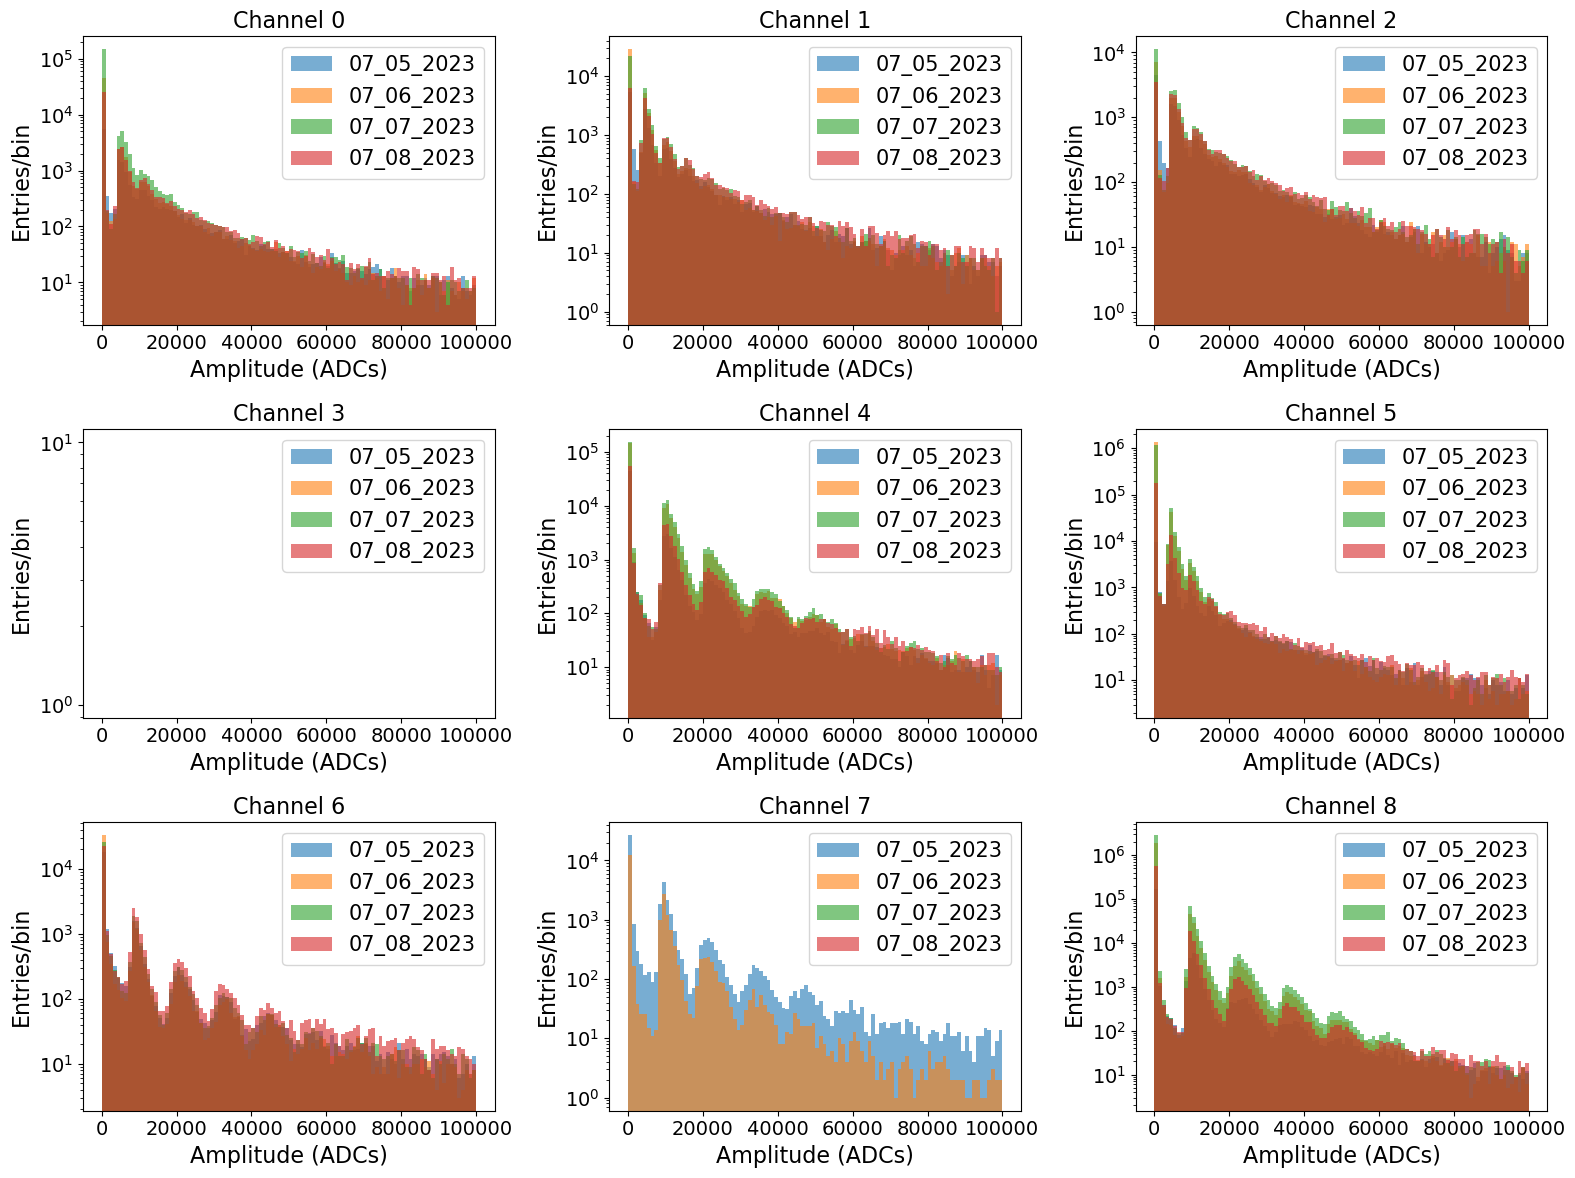

In [39]:
print('')
print('                      ---------------------------------------')
print('                      -- 0.2 ppm XENON (high light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '07_05_2023'
select_date2 = '07_06_2023'
select_date3 = '07_07_2023'
select_date4 = '07_08_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date1][k], bins=100, range=(0,100000), log=True, label=f'{select_date1}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date2][k], bins=100, range=(0,100000), log=True, label=f'{select_date2}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date3][k], bins=100, range=(0,100000), log=True, label=f'{select_date3}', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date4][k], bins=100, range=(0,100000), log=True, label=f'{select_date4}', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()

## Compare the different amount of Xenon


                      ---------------------------------------
                      --- Peak integ ZS (low light levels) --
                      ---------------------------------------



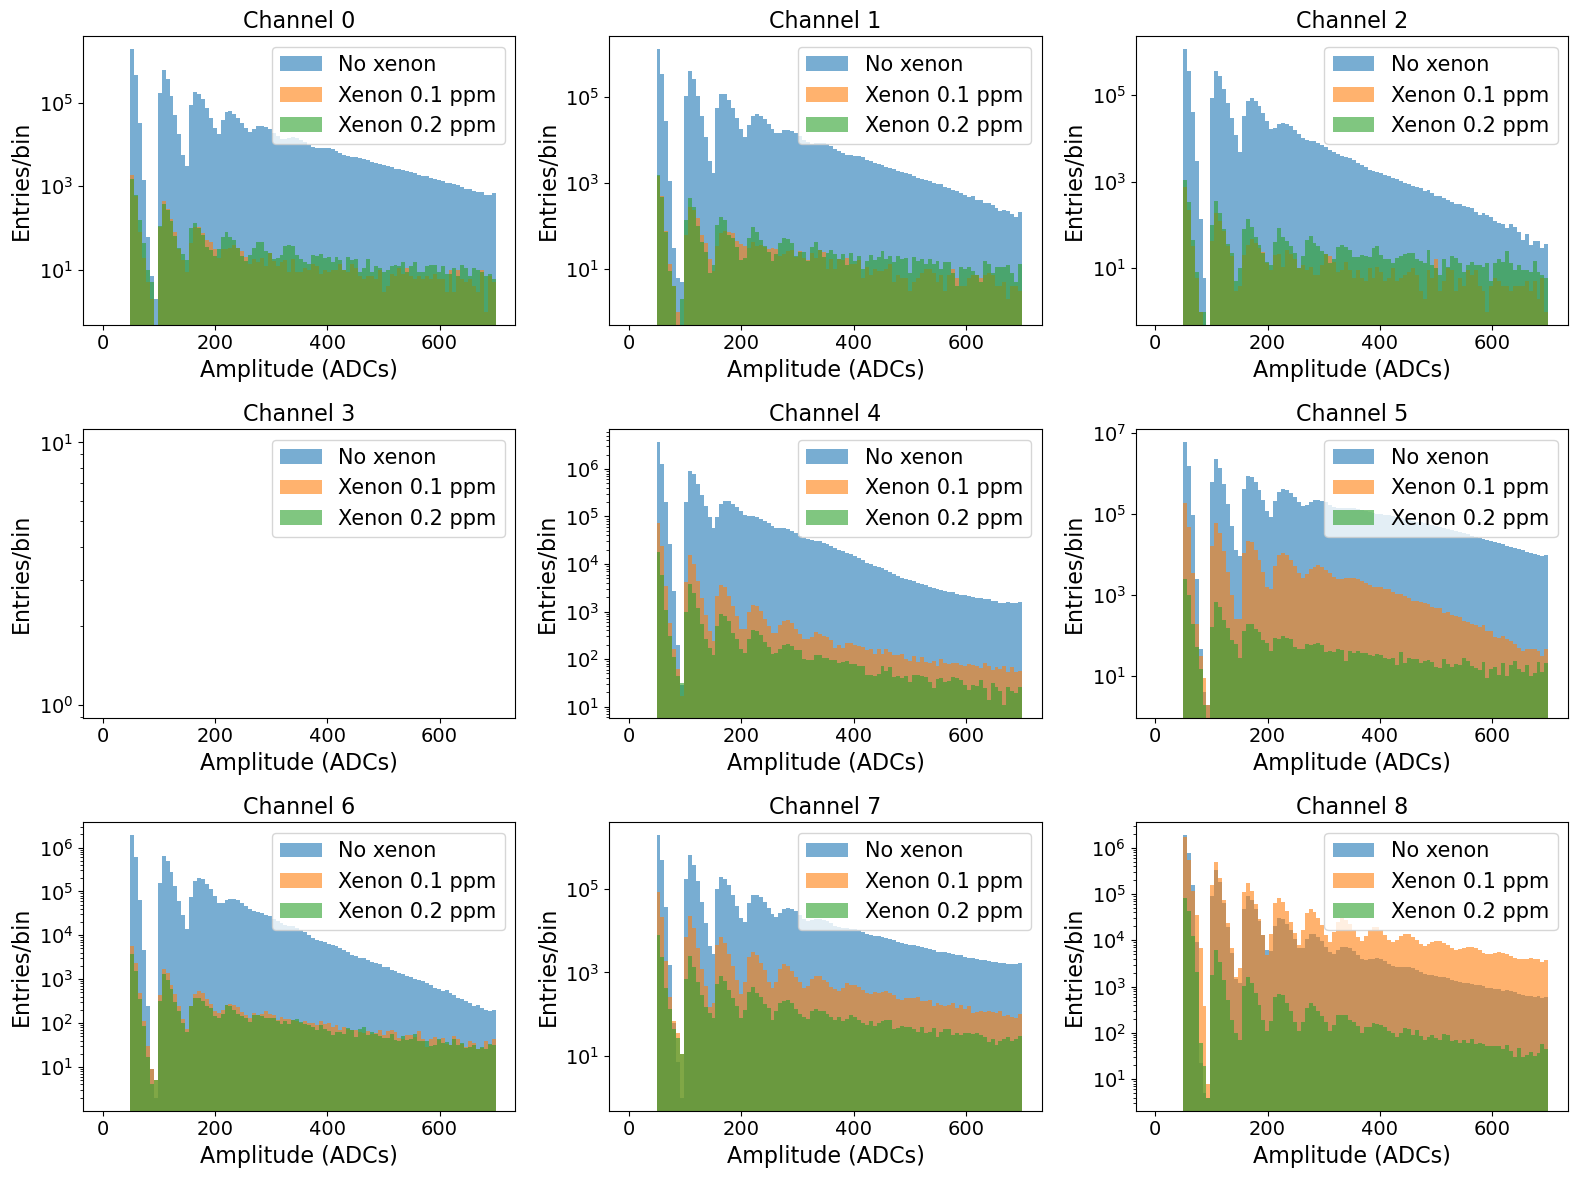

In [40]:
print('')
print('                      ---------------------------------------')
print('                      --- Peak integ ZS (low light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '05_30_2023'
select_date2 = '06_20_2023'
select_date3 = '07_05_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date1][k], bins=100, range=(0,700), log=True, label=f'No xenon', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date2][k], bins=100, range=(0,700), log=True, label=f'Xenon 0.1 ppm', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date3][k], bins=100, range=(0,700), log=True, label=f'Xenon 0.2 ppm', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      -- Peak integ ZS (high light levels) --
                      ---------------------------------------



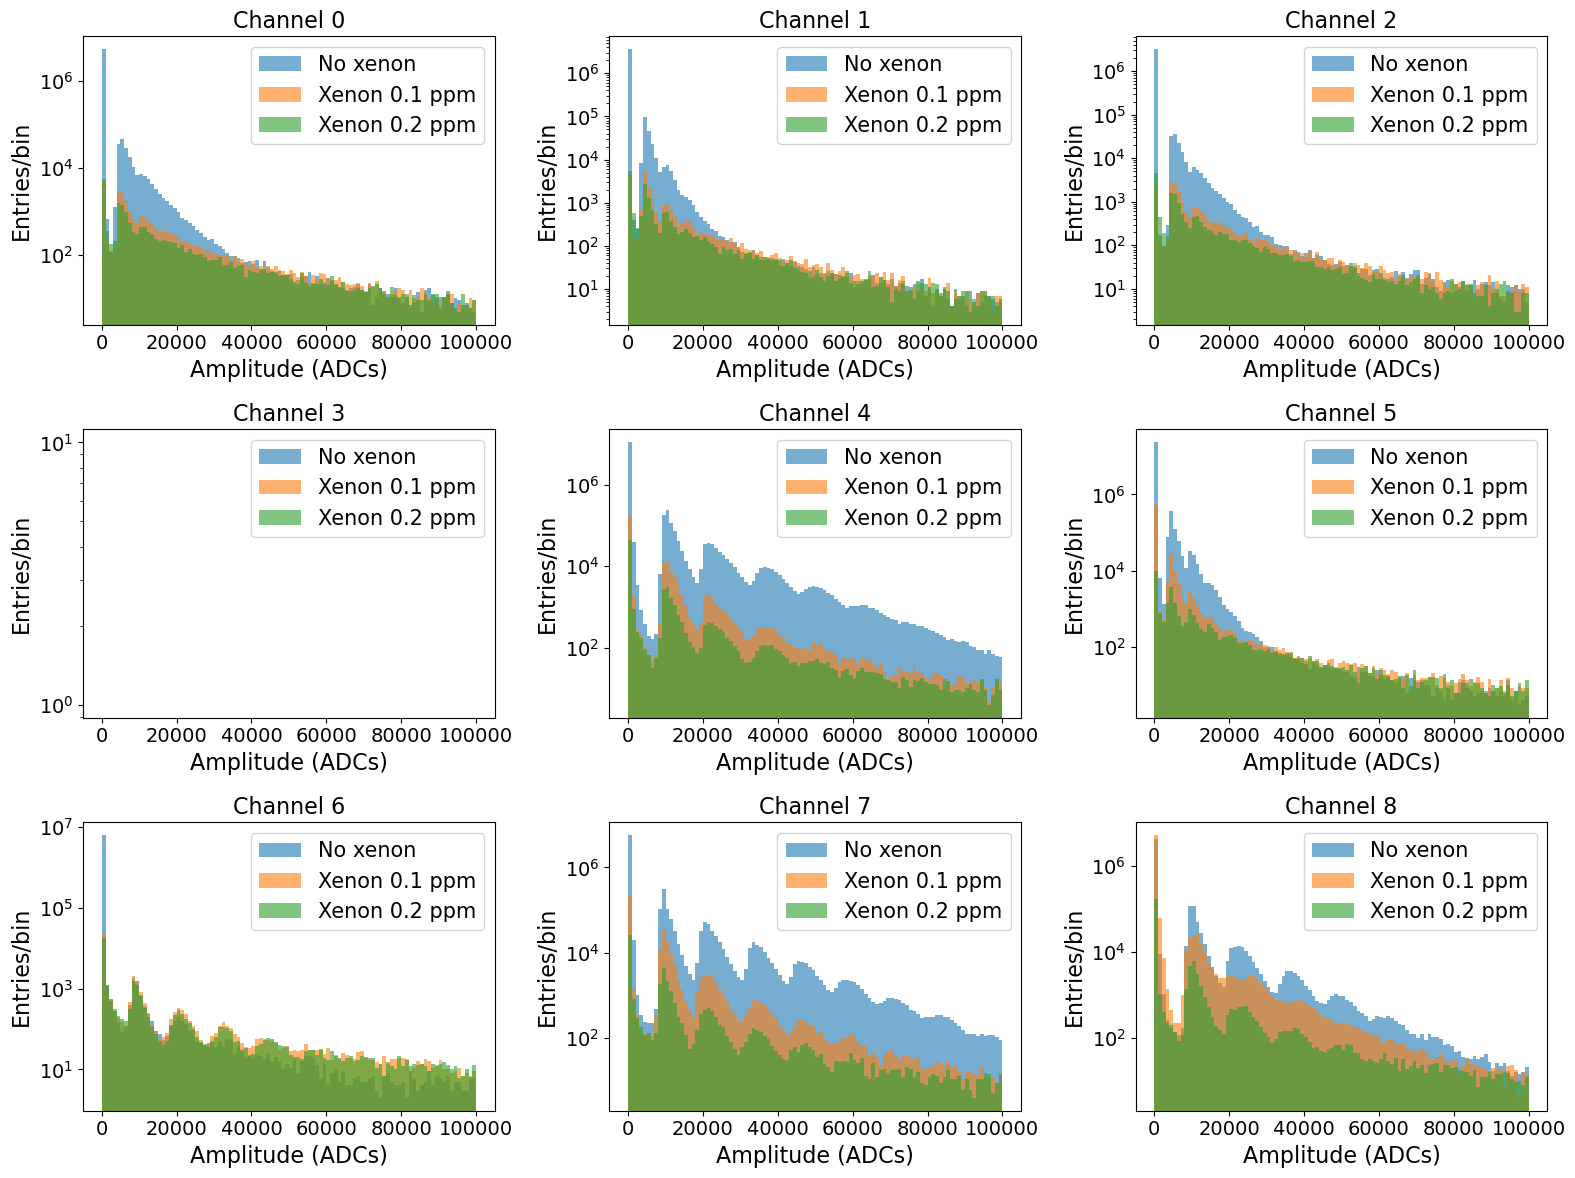

In [41]:
print('')
print('                      ---------------------------------------')
print('                      -- Peak integ ZS (high light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '05_30_2023'
select_date2 = '06_20_2023'
select_date3 = '07_05_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date1][k], bins=100, range=(0,100000), log=True, label=f'No xenon', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date2][k], bins=100, range=(0,100000), log=True, label=f'Xenon 0.1 ppm', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date3][k], bins=100, range=(0,100000), log=True, label=f'Xenon 0.2 ppm', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()


                      ---------------------------------------
                      --- Peak integ 1 (high light levels) --
                      ---------------------------------------



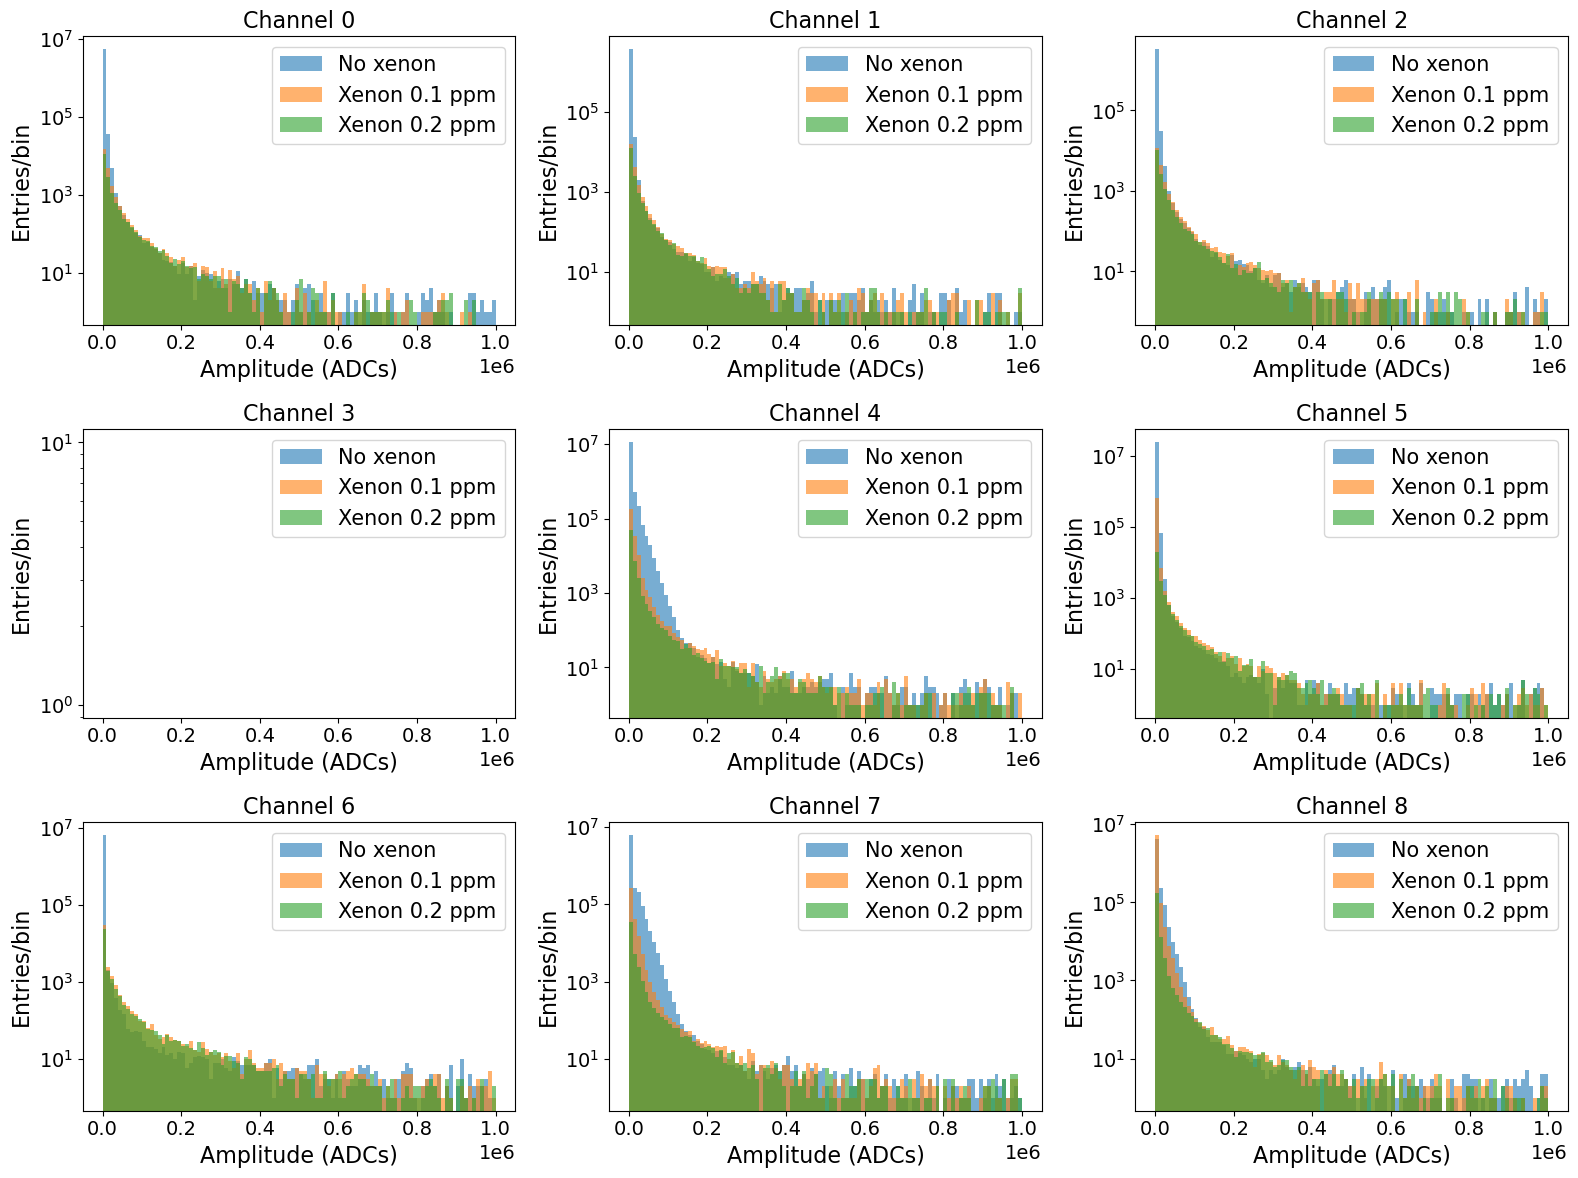

In [42]:
print('')
print('                      ---------------------------------------')
print('                      --- Peak integ 1 (high light levels) --')
print('                      ---------------------------------------')
print('')

select_date1 = '05_30_2023'
select_date2 = '06_20_2023'
select_date3 = '07_05_2023'

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date1][k], bins=100, range=(0,1000000), log=True, label=f'No xenon', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date2][k], bins=100, range=(0,1000000), log=True, label=f'Xenon 0.1 ppm', alpha=0.6)
    axs[i][j].hist(peak_area_zs_all_channels_dict[select_date3][k], bins=100, range=(0,1000000), log=True, label=f'Xenon 0.2 ppm', alpha=0.6)
    axs[i][j].set_xlabel('Amplitude (ADCs)', fontsize=16)
    axs[i][j].set_ylabel('Entries/bin',      fontsize=16)
    axs[i][j].set_title(f"Channel {k}",      fontsize=16)
    axs[i][j].legend(fontsize=15)
plt.tight_layout()
plt.show()